## Import Libraries

In [1]:
from UFCStats.queries import DatabaseQuery

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import dataframe_image as dfi

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import pickle

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

from scipy.cluster.hierarchy import dendrogram
from scipy.spatial import distance

from math import ceil

## Run Database Queries

In [2]:
# Run queries to add db data to pandas dataframes
DQ = DatabaseQuery()

def query_to_df(query):
    df = pd.DataFrame(query.fetchall())
    df.columns = query.keys()
    return df

In [3]:
# Query database for fight details
fight_cols = ['fight_id', 'event_id', 'weightclass', 'rds_sched', 'rd_ended', 'method', 'bonus', 
              'fighter_1_id', 'fighter_2_id', 'winner_id', 'tapology_rank', 'deductions']

fight_col_str = ', '.join(fight_cols)

fight_details = query_to_df(DQ.engine.execute('SELECT ' + fight_col_str + ' FROM fights'))

# Query database for round information
round_details = query_to_df(DQ.engine.execute('SELECT rd_id, fight_id, rd_num, rd_length FROM rounds'))

# Query database for event dates
event_dates = query_to_df(DQ.engine.execute('SELECT event_id, event_date FROM events'))

# Query database for fighter information
fighter_details = query_to_df(DQ.engine.execute('SELECT * FROM fighters'))

# Query database for fight statistics by round
result_cols = ['rd_id', 'fighter_id', 'kd', 'sig_head_land', 'sig_head_att', 'sig_body_land', 
               'sig_body_att', 'sig_leg_land', 'sig_leg_att', 'sig_dist_land', 'sig_dist_att',
               'sig_clinch_land', 'sig_clinch_att', 'sig_ground_land', 'sig_ground_att', 
               'total_strike_land', 'total_strike_att', 'takedown_land', 'takedown_att', 'sub_att',
               'reversals', 'ctrl_time', 'kd_taken', 'sig_head_taken', 'sig_head_seen', 
               'sig_body_taken', 'sig_body_seen', 'sig_leg_taken', 'sig_leg_seen', 'sig_dist_taken',
               'sig_dist_seen', 'sig_clinch_taken', 'sig_clinch_seen', 'sig_ground_taken', 
               'sig_ground_seen', 'total_strike_taken', 'total_strike_seen', 'takedown_taken', 
               'takedown_seen', 'sub_seen', 'reversals_taken', 'ctrl_time_taken']

result_col_str = ', '.join(result_cols)

stats_by_round = query_to_df(DQ.engine.execute('SELECT ' + result_col_str + ' FROM round_results'))

In [4]:
fight_details.head()

,fight_id,event_id,weightclass,rds_sched,rd_ended,method,bonus,fighter_1_id,fighter_2_id,winner_id,tapology_rank,deductions
0,6f62436ae042009b,20bd6c3e03c46ee6,Heavyweight,5,5,Decision - Unanimous,belt,0aa92558424ced9e,b44f39a5c6596953,0aa92558424ced9e,70.0,None
1,0031c043c9f14eb8,cfb65863d5099327,Welterweight,3,3,KO/TKO,fight,f9f07bb5a43535ed,cbd5d3cdd862e90e,f9f07bb5a43535ed,62.0,None
2,82177c0f91d9618a,4565d435005319c0,Welterweight,5,5,KO/TKO,"belt, fight",f1b2aa7853d1ed6e,dc9572dd6ec74859,f1b2aa7853d1ed6e,59.0,None
3,d9c61052035c9b69,140745cbbcb023ac,Heavyweight,5,2,Submission,"belt, sub",513c6f1715e547a8,68dd7b3783c19f9c,513c6f1715e547a8,58.0,None
4,652a73f4bf7f1932,4f7e290e71d60f87,Heavyweight,3,1,KO/TKO,fight,3236bf606fe9fa5b,3738e68d2261e60f,3738e68d2261e60f,56.0,None


In [5]:
round_details.head()

,rd_id,fight_id,rd_num,rd_length
0,41622791b276ad9e-1,41622791b276ad9e,1,300
1,41622791b276ad9e-2,41622791b276ad9e,2,300
2,41622791b276ad9e-3,41622791b276ad9e,3,296
3,81af3b60203d92df-1,81af3b60203d92df,1,300
4,81af3b60203d92df-2,81af3b60203d92df,2,300


In [6]:
stats_by_round.head()

,rd_id,fighter_id,kd,sig_head_land,sig_head_att,sig_body_land,sig_body_att,sig_leg_land,sig_leg_att,sig_dist_land,...,sig_clinch_seen,sig_ground_taken,sig_ground_seen,total_strike_taken,total_strike_seen,takedown_taken,takedown_seen,sub_seen,reversals_taken,ctrl_time_taken
0,41622791b276ad9e-1,8e9eb3fc86db0f7d,0,16,38,3,5,3,4,17,...,21,0,0,66,108,0,0,0,0,80.0
1,41622791b276ad9e-1,46d0a888d87d91ac,0,12,42,29,39,5,6,28,...,7,0,0,34,59,0,0,0,0,70.0
2,41622791b276ad9e-2,8e9eb3fc86db0f7d,0,52,120,5,5,3,3,51,...,12,0,0,61,119,0,2,0,0,43.0
3,41622791b276ad9e-2,46d0a888d87d91ac,0,29,80,18,24,8,8,47,...,14,0,0,66,134,0,1,0,0,43.0
4,41622791b276ad9e-3,8e9eb3fc86db0f7d,1,58,99,1,1,0,0,15,...,0,0,0,15,34,0,1,0,0,0.0


In [7]:
# Add columns for significant strikes landed and attempted by the fighter and the opponent
stats_by_round['total_sig_land'] = stats_by_round['sig_head_land'] + stats_by_round['sig_body_land'] + stats_by_round['sig_leg_land']
stats_by_round['total_sig_att'] = stats_by_round['sig_head_att'] + stats_by_round['sig_body_att'] + stats_by_round['sig_leg_att']
stats_by_round['total_sig_land_opp'] = stats_by_round['sig_head_taken'] + stats_by_round['sig_body_taken'] + stats_by_round['sig_leg_taken']
stats_by_round['total_sig_att_opp'] = stats_by_round['sig_head_seen'] + stats_by_round['sig_body_seen'] + stats_by_round['sig_leg_seen']

In [8]:
# Merge round number and round length to fight stats table
stats_by_round = stats_by_round.merge(round_details[['rd_id', 'rd_num', 'rd_length']],
                                      on='rd_id',
                                      how='left'
                                     )

In [9]:
# Drop all rounds where control time was not provided on UFCStats.com (NaN)
stats_by_round.dropna(subset=['ctrl_time', 'ctrl_time_taken'], inplace=True)

In [10]:
# Create columns for neutral time and control time plus neutral time
stats_by_round['ctrl_plus_neutral'] = stats_by_round['rd_length'] - stats_by_round['ctrl_time_taken']
stats_by_round['neutral_time'] = stats_by_round['ctrl_plus_neutral'] - stats_by_round['ctrl_time']

In [11]:
# Group stats by fighter and by fighter AND round to be used for calculating different features
grouped_by_round = stats_by_round.groupby(['fighter_id', 'rd_num']).sum().reset_index()
grouped_by_fighter = stats_by_round.groupby('fighter_id').sum().reset_index()

## Calculate Clustering Metrics

#### Per Minute of Control/Neutral Time

In [12]:
# Calculate stats per minute of control/neutral time
per_ctrl_plus_neutral_cols = ['fighter_id', 'kd', 'kd_taken', 'total_sig_land', 'total_sig_att', 'total_strike_land', 'total_strike_att',
                              'total_sig_land_opp', 'total_strike_taken', 'sub_att', 'ctrl_plus_neutral']

per_ctrl_plus_neutral = grouped_by_fighter[per_ctrl_plus_neutral_cols].copy(deep=True)

per_ctrl_plus_neutral.iloc[:, 1:] = per_ctrl_plus_neutral.iloc[:, 1:].div(per_ctrl_plus_neutral['ctrl_plus_neutral'], axis=0).multiply(60, axis=0)

In [13]:
# Rename columns to reflect "per minute"
per_ctrl_plus_neutral.columns = ['fighter_id', 'kd_per_min', 'kd_taken_per_min', 'sig_land_per_min', 'sig_att_per_min', 'strike_land_per_min',
                                 'strike_att_per_min', 'sig_absorbed_per_min', 'strike_absorbed_per_min', 'sub_att_per_min', 'ctrl_plus_neutral'
                                ]

In [14]:
per_ctrl_plus_neutral.head()

,fighter_id,kd_per_min,kd_taken_per_min,sig_land_per_min,sig_att_per_min,strike_land_per_min,strike_att_per_min,sig_absorbed_per_min,strike_absorbed_per_min,sub_att_per_min,ctrl_plus_neutral
0,002ca196477ce572,0.000000,0.000000,2.500000,7.243590,6.474359,12.051282,6.666667,8.653846,0.064103,60.0
1,003d82fa384ca1d0,0.000000,0.491803,0.983607,7.377049,0.983607,7.377049,31.967213,41.311475,0.000000,60.0
2,0052de90691d4a93,0.000000,0.014695,2.983101,7.905952,3.952976,9.022777,3.894195,5.143277,0.044085,60.0
3,008dc37cca279def,0.000000,0.000000,1.674419,3.767442,2.790698,5.023256,4.883721,11.860465,0.558140,60.0
4,008ea710276c9606,0.168067,0.000000,13.221289,23.417367,17.703081,28.515406,7.619048,8.739496,0.000000,60.0


#### Per Minute of Neutral Time

In [15]:
# Calculate stats per minute of neutral time
per_neutral_cols = ['fighter_id', 'takedown_att', 'takedown_land', 'takedown_taken', 'neutral_time']

per_neutral = grouped_by_fighter[per_neutral_cols].copy(deep=True)

per_neutral.iloc[:, 1:] = per_neutral.iloc[:, 1:].div(per_neutral['neutral_time'], axis=0).multiply(60, axis=0)

In [16]:
# Rename columns to reflect "per minute"
per_neutral.columns = ['fighter_id', 'takedown_att_per_min', 'takedown_land_per_min', 'takedown_absorbed_per_min', 'neutral_time']

In [17]:
per_neutral.head()

,fighter_id,takedown_att_per_min,takedown_land_per_min,takedown_absorbed_per_min,neutral_time
0,002ca196477ce572,1.381958,0.345489,0.921305,60.0
1,003d82fa384ca1d0,1.698113,0.000000,0.000000,60.0
2,0052de90691d4a93,0.450992,0.180397,0.018040,60.0
3,008dc37cca279def,1.807229,0.722892,0.722892,60.0
4,008ea710276c9606,0.072993,0.000000,0.218978,60.0


#### Per Minute of Total Time

In [18]:
# Calculate stats per minute of total time (rd_length)
per_total_time_cols = ['fighter_id', 'ctrl_time', 'ctrl_time_taken', 'rd_length']

per_total_time = grouped_by_fighter[per_total_time_cols].copy(deep=True)

per_total_time.iloc[:, 1:] = per_total_time.iloc[:, 1:].div(per_total_time['rd_length'], axis=0).multiply(60, axis=0)

In [19]:
# Rename columns to reflect "per minute"
per_total_time.columns = ['fighter_id', 'ctrl_time_per_min', 'ctrl_time_opp_per_min', 'rd_length']

In [20]:
per_total_time.head()

,fighter_id,ctrl_time_per_min,ctrl_time_opp_per_min,rd_length
0,002ca196477ce572,13.833333,28.800000,60.0
1,003d82fa384ca1d0,5.189189,20.432432,60.0
2,0052de90691d4a93,9.826915,6.996971,60.0
3,008dc37cca279def,18.679245,29.575472,60.0
4,008ea710276c9606,11.990369,8.426966,60.0


#### Fight Metric Ratios

In [21]:
# Copy the stats by fighter table
metric_ratios = grouped_by_fighter.copy(deep=True)

In [22]:
# Create fight metric ratio columns
metric_ratios['ctrl_time_ratio'] = metric_ratios['ctrl_time'] / metric_ratios['ctrl_time_taken']
metric_ratios['takedown_perc'] = metric_ratios['takedown_land'] / metric_ratios['takedown_att']
metric_ratios['opp_takedown_perc'] = metric_ratios['takedown_taken'] / metric_ratios['takedown_seen']
metric_ratios['leg_strike_rate'] = metric_ratios['sig_leg_att'] / metric_ratios['total_sig_att']
metric_ratios['body_strike_rate'] = metric_ratios['sig_body_att'] / metric_ratios['total_sig_att']
metric_ratios['head_strike_rate'] = metric_ratios['sig_head_att'] / metric_ratios['total_sig_att']
metric_ratios['dist_strike_rate'] = metric_ratios['sig_dist_att'] / metric_ratios['total_sig_att']
metric_ratios['clinch_strike_rate'] = metric_ratios['sig_clinch_att'] / metric_ratios['total_sig_att']
metric_ratios['ground_strike_rate'] = metric_ratios['sig_ground_att'] / metric_ratios['total_sig_att']
metric_ratios['leg_strike_acc'] = metric_ratios['sig_leg_land'] / metric_ratios['sig_leg_att']
metric_ratios['body_strike_acc'] = metric_ratios['sig_body_land'] / metric_ratios['sig_body_att']
metric_ratios['head_strike_acc'] = metric_ratios['sig_head_land'] / metric_ratios['sig_head_att']
metric_ratios['dist_strike_acc'] = metric_ratios['sig_dist_land'] / metric_ratios['sig_dist_att']
metric_ratios['clinch_strike_acc'] = metric_ratios['sig_clinch_land'] / metric_ratios['sig_clinch_att']
metric_ratios['ground_strike_acc'] = metric_ratios['sig_ground_land'] / metric_ratios['sig_ground_att']
metric_ratios['sig_strike_acc'] = metric_ratios['total_sig_land'] / metric_ratios['total_sig_att']
metric_ratios['opp_sig_strike_acc'] = metric_ratios['total_sig_land_opp'] / metric_ratios['total_sig_att_opp']
metric_ratios['total_strike_acc'] = metric_ratios['total_strike_land'] / metric_ratios['total_strike_att']
metric_ratios['opp_total_strike_acc'] = metric_ratios['total_strike_taken'] / metric_ratios['total_strike_seen']
metric_ratios['kd_per_sig_strike'] = metric_ratios['kd'] / metric_ratios['total_sig_att']
metric_ratios['kd_per_sig_head_strike'] = metric_ratios['kd'] / metric_ratios['sig_head_att']
metric_ratios['opp_kd_per_sig_strike'] = metric_ratios['kd_taken'] / metric_ratios['total_sig_att_opp']
metric_ratios['opp_kd_per_sig_head_strike'] = metric_ratios['kd_taken'] / metric_ratios['sig_head_seen']

In [23]:
# Filter the metric ratios table to ratio columns only
metric_ratio_cols = ['fighter_id',
                     'ctrl_time_ratio',
                     'takedown_perc',
                     'opp_takedown_perc',
                     'leg_strike_rate',
                     'body_strike_rate',
                     'head_strike_rate',
                     'dist_strike_rate',
                     'clinch_strike_rate',
                     'ground_strike_rate',
                     'leg_strike_acc',
                     'body_strike_acc',
                     'head_strike_acc',
                     'dist_strike_acc',
                     'clinch_strike_acc',
                     'ground_strike_acc',
                     'sig_strike_acc',
                     'opp_sig_strike_acc',
                     'total_strike_acc',
                     'opp_total_strike_acc',
                     'kd_per_sig_strike',
                     'kd_per_sig_head_strike',
                     'opp_kd_per_sig_strike',
                     'opp_kd_per_sig_head_strike']

metric_ratios = metric_ratios[metric_ratio_cols]

In [24]:
metric_ratios.head()

,fighter_id,ctrl_time_ratio,takedown_perc,opp_takedown_perc,leg_strike_rate,body_strike_rate,head_strike_rate,dist_strike_rate,clinch_strike_rate,ground_strike_rate,...,clinch_strike_acc,ground_strike_acc,sig_strike_acc,opp_sig_strike_acc,total_strike_acc,opp_total_strike_acc,kd_per_sig_strike,kd_per_sig_head_strike,opp_kd_per_sig_strike,opp_kd_per_sig_head_strike
0,002ca196477ce572,0.480324,0.25,0.615385,0.035398,0.088496,0.876106,0.893805,0.061947,0.044248,...,0.428571,0.600000,0.345133,0.544503,0.537234,0.589520,0.000000,0.000000,0.000000,0.000000
1,003d82fa384ca1d0,0.253968,0.00,NaN,0.266667,0.333333,0.400000,1.000000,0.000000,0.000000,...,NaN,NaN,0.133333,0.706522,0.133333,0.750000,0.000000,0.000000,0.010870,0.011364
2,0052de90691d4a93,1.404453,0.40,0.166667,0.050186,0.135688,0.814126,0.890335,0.050186,0.059480,...,0.740741,0.750000,0.377323,0.436573,0.438111,0.495050,0.000000,0.000000,0.001647,0.002165
3,008dc37cca279def,0.631579,0.40,0.666667,0.000000,0.074074,0.925926,0.555556,0.037037,0.407407,...,0.000000,0.636364,0.444444,0.479452,0.555556,0.643939,0.000000,0.000000,0.000000,0.000000
4,008ea710276c9606,1.422857,0.00,0.500000,0.019139,0.066986,0.913876,0.856459,0.023923,0.119617,...,1.000000,0.780000,0.564593,0.480565,0.620825,0.509804,0.007177,0.007853,0.000000,0.000000


#### Finish Metrics

In [25]:
# Adjust fight detail table such that each row represents a fighter's performance in a single fight
finish_details_f1 = fight_details[['fight_id', 'method', 'fighter_1_id', 'winner_id']].copy()
finish_details_f2 = fight_details[['fight_id', 'method', 'fighter_2_id', 'winner_id']].copy()

finish_details_f1.columns = ['fight_id', 'method', 'fighter_id', 'winner_id']
finish_details_f2.columns = ['fight_id', 'method', 'fighter_id', 'winner_id']

finish_details = pd.concat([finish_details_f1, finish_details_f2]).sort_values('fight_id').reset_index(drop=True)

In [26]:
# Replace values in the method column
method_dict = {'Decision - Unanimous' : 'decision',
               'Decision - Split' : 'decision',
               'Decision - Majority' : 'decision',
               'KO/TKO' : 'tko',
               'TKO - Doctor\'s Stoppage' : 'tko',
               'Could Not Continue' : 'tko',
               'Overturned' : 'exclude',
               'Other' : 'exclude',
               'DQ' : 'exclude',
               'Submission' : 'sub'
              }

finish_details.replace({'method': method_dict}, inplace=True)

In [27]:
# Add results column to reflect win/loss/draw and method
finish_details['result'] = np.where(finish_details['fighter_id']==finish_details['winner_id'], 'win',
                                    np.where(finish_details['winner_id']=='Draw', 'draw',
                                             np.where(finish_details['winner_id']=='NC', 'no contest', 'loss' )                                                    
                                            )
                                   )

finish_details = finish_details[(~finish_details['result'].isin(['no contest'])) &
                                (~finish_details['method'].isin(['exclude']))
                               ]

finish_details['result_method'] = finish_details['result'] + ' - ' + finish_details['method']

In [28]:
# Group finish details by method and count instances of winner and method combinations
finish_counts = finish_details.groupby(['fighter_id', 'result_method']).size().unstack(fill_value=0).reset_index()

# Merge sub attempts columns
sub_cols = ['fighter_id', 'sub_att', 'sub_seen']
finish_counts = finish_counts.merge(grouped_by_fighter[sub_cols]) 

# Create aggregate columns for win/loss rate calculations
finish_counts['finish_wins'] = finish_counts['win - tko'] + finish_counts['win - sub']
finish_counts['finish_losses'] = finish_counts['loss - tko'] + finish_counts['loss - sub']
finish_counts['num_fights'] = finish_counts.iloc[:, 1:8].sum(axis=1)
finish_counts['num_wins'] = finish_counts['win - decision'] + finish_counts['win - sub'] + finish_counts['win - tko']
finish_counts['num_losses'] = finish_counts['loss - decision'] + finish_counts['loss - sub'] + finish_counts['loss - tko']

In [29]:
# Calculate LOSS rates by different methods, both in terms of versus total fights and total wins
finish_counts['tko_win_per_fight'] = finish_counts['win - tko'] / finish_counts['num_fights']
finish_counts['sub_win_per_fight'] = finish_counts['win - sub'] / finish_counts['num_fights']
finish_counts['dec_win_per_fight'] = finish_counts['win - decision'] / finish_counts['num_fights']
finish_counts['tko_win_per_win'] = finish_counts['win - tko'] / finish_counts['num_wins']
finish_counts['sub_win_per_win'] = finish_counts['win - sub'] / finish_counts['num_wins']
finish_counts['dec_win_per_win'] = finish_counts['win - decision'] / finish_counts['num_wins']

# Calculate LOSS rates by different methods, both in terms of versus total fights and total wins
finish_counts['tko_loss_per_fight'] = finish_counts['loss - tko'] / finish_counts['num_fights']
finish_counts['sub_loss_per_fight'] = finish_counts['loss - sub'] / finish_counts['num_fights']
finish_counts['dec_loss_per_fight'] = finish_counts['loss - decision'] / finish_counts['num_fights']
finish_counts['tko_loss_per_loss'] = finish_counts['loss - tko'] / finish_counts['num_losses']
finish_counts['sub_loss_per_loss'] = finish_counts['loss - sub'] / finish_counts['num_losses']
finish_counts['dec_loss_per_loss'] = finish_counts['loss - decision'] / finish_counts['num_losses']

# Calculate submission success rate for fighter and opponent  (DOESN'T CALC PROPERLY)
#finish_counts['sub_success_rate'] = finish_counts['win - sub'] / finish_counts['sub_att']
#finish_counts['opp_sub_success_rate'] = finish_counts['loss - sub'] / finish_counts['sub_seen']

# Calculate total finish rate and opponent finish rate
finish_counts['finish_rate'] = finish_counts['finish_wins'] / finish_counts['num_fights']
finish_counts['opp_finish_rate'] = finish_counts['finish_losses'] / finish_counts['num_fights']

In [30]:
# Filter to final columns
final_finish_cols = ['fighter_id', 'num_fights', 'tko_win_per_fight', 'sub_win_per_fight', 'dec_win_per_fight',
                     'tko_win_per_win', 'sub_win_per_win', 'dec_win_per_win', 'tko_loss_per_fight',
                     'sub_loss_per_fight', 'dec_loss_per_fight', 'tko_loss_per_loss', 'sub_loss_per_loss',
                     'dec_loss_per_loss', 'finish_rate',
                     'opp_finish_rate'
                    ]

finish_counts = finish_counts[final_finish_cols]

In [31]:
finish_counts.sort_values('num_fights', ascending=False).head()

,fighter_id,num_fights,tko_win_per_fight,sub_win_per_fight,dec_win_per_fight,tko_win_per_win,sub_win_per_win,dec_win_per_win,tko_loss_per_fight,sub_loss_per_fight,dec_loss_per_fight,tko_loss_per_loss,sub_loss_per_loss,dec_loss_per_loss,finish_rate,opp_finish_rate
1712,d1941565abf50b16,37,0.108108,0.270270,0.216216,0.181818,0.454545,0.363636,0.054054,0.081081,0.270270,0.133333,0.200000,0.666667,0.378378,0.135135
212,1d00756835ca67c9,36,0.277778,0.166667,0.194444,0.434783,0.260870,0.304348,0.222222,0.000000,0.138889,0.615385,0.000000,0.384615,0.444444,0.222222
457,3738e68d2261e60f,35,0.257143,0.057143,0.285714,0.428571,0.095238,0.476190,0.200000,0.057143,0.142857,0.500000,0.142857,0.357143,0.314286,0.257143
175,18968f97ad34f15c,33,0.242424,0.000000,0.212121,0.533333,0.000000,0.466667,0.090909,0.090909,0.363636,0.166667,0.166667,0.666667,0.242424,0.181818
536,427b5953ac8e3a27,33,0.030303,0.333333,0.303030,0.045455,0.500000,0.454545,0.060606,0.000000,0.272727,0.181818,0.000000,0.818182,0.363636,0.060606


#### Control and Strike Pacing

In [32]:
# Merge number of rounds scheduled to round by round stats
stats_by_round['fight_id'] = stats_by_round['rd_id'].str.split('-').str[0]
stats_by_round= stats_by_round.merge(fight_details[['fight_id', 'rds_sched']], on='fight_id')

In [33]:
# Tag rounds as early or late
stats_by_round['early_late'] = np.where(stats_by_round['rds_sched']=='3', np.where(stats_by_round['rd_num']<=2, 'early', 'late'),
                                        np.where(stats_by_round['rd_num']<=3, 'early', 'late')
                                       )

In [34]:
# Group stats by round by early and late rounds for each fighter
pace_cols = ['fighter_id', 'early_late', 'rd_length', 'ctrl_time', 'ctrl_time_taken', 'total_sig_land', 'total_sig_land_opp']
pace_metrics = stats_by_round[pace_cols].groupby(['fighter_id', 'early_late']).sum().reset_index()

In [35]:
# Split into two tables, early and late rounds
pace_metrics = pace_metrics.sort_values(['early_late', 'fighter_id'])
early = pace_metrics[pace_metrics['early_late']=='early'].reset_index(drop=True)
late = pace_metrics[pace_metrics['early_late']=='late'].reset_index(drop=True)

# Rename columns
early.columns = ['fighter_id', 'early_late', 'rd_length_early', 'ctrl_time_early', 'ctrl_time_taken_early', 'total_sig_land_early', 'total_sig_land_opp_early']
late.columns = ['fighter_id', 'early_late', 'rd_length_late', 'ctrl_time_late', 'ctrl_time_taken_late', 'total_sig_land_late', 'total_sig_land_opp_late']

# Recombine early and late metrics
pace_metrics = late.merge(early, on='fighter_id')

In [36]:
# Calculate pacing metrics for control and strike rates in early vs late rounds
pace_metrics['control_rate_early'] = pace_metrics['ctrl_time_early'] / pace_metrics['rd_length_early']
pace_metrics['control_rate_late'] = pace_metrics['ctrl_time_late'] / pace_metrics['rd_length_late']
pace_metrics['control_rate_late_vs_early'] = pace_metrics['control_rate_late'] / pace_metrics['control_rate_early']
pace_metrics['sig_strike_rate_early'] = pace_metrics['total_sig_land_early'] / pace_metrics['rd_length_early']
pace_metrics['sig_strike_rate_late'] = pace_metrics['total_sig_land_late'] / pace_metrics['rd_length_late']
pace_metrics['sig_strike_rate_late_vs_early'] = pace_metrics['sig_strike_rate_late'] / pace_metrics['sig_strike_rate_early']

In [37]:
# Filter to the final table of pace metrics
final_pace_cols = ['fighter_id', 'control_rate_late_vs_early', 'sig_strike_rate_late_vs_early']
pace_metrics = pace_metrics[final_pace_cols]

In [38]:
pace_metrics.head()

,fighter_id,control_rate_late_vs_early,sig_strike_rate_late_vs_early
0,002ca196477ce572,0.080201,0.363636
1,0052de90691d4a93,0.569733,0.858327
2,008ea710276c9606,0.000000,3.674067
3,00a3ff40c4b2cf21,0.414340,0.775217
4,00debc804e2b1cd4,0.202098,3.218599


## Merge Clustering Metrics

In [39]:
# Start with finish metrics, filtered for fighters with 10+ fights
cluster_metrics = finish_counts[finish_counts['num_fights'] >= 10].copy()
cluster_metrics = cluster_metrics.merge(per_ctrl_plus_neutral.iloc[:, 0:-1], on='fighter_id')
cluster_metrics = cluster_metrics.merge(per_neutral.iloc[:, 0:-1], on='fighter_id')
cluster_metrics = cluster_metrics.merge(per_total_time.iloc[:, 0:-1], on='fighter_id')
cluster_metrics = cluster_metrics.merge(metric_ratios, on='fighter_id')

# Filter out all fighters that do not have 20+ rounds of data
num_rounds = stats_by_round.groupby('fighter_id')['fight_id'].count().reset_index()
fighters_above_limit = list(num_rounds[num_rounds['fight_id'] >= 15]['fighter_id'])
cluster_metrics = cluster_metrics[cluster_metrics['fighter_id'].isin(fighters_above_limit)]

In [40]:
cluster_metrics

,fighter_id,num_fights,tko_win_per_fight,sub_win_per_fight,dec_win_per_fight,tko_win_per_win,sub_win_per_win,dec_win_per_win,tko_loss_per_fight,sub_loss_per_fight,...,clinch_strike_acc,ground_strike_acc,sig_strike_acc,opp_sig_strike_acc,total_strike_acc,opp_total_strike_acc,kd_per_sig_strike,kd_per_sig_head_strike,opp_kd_per_sig_strike,opp_kd_per_sig_head_strike
0,00e11b5c8b7bfeeb,10,0.300000,0.300000,0.000000,0.500000,0.500000,0.000000,0.400000,0.000000,...,0.727273,0.736842,0.549915,0.473214,0.589820,0.534113,0.003384,0.004662,0.011161,0.015480
1,01b352b6a9074d5c,11,0.181818,0.000000,0.090909,0.666667,0.000000,0.333333,0.272727,0.090909,...,0.736842,0.714286,0.456118,0.483487,0.479141,0.503755,0.001281,0.001717,0.001982,0.002333
2,029880cdbf5ca089,12,0.083333,0.083333,0.500000,0.125000,0.125000,0.750000,0.166667,0.000000,...,0.481481,0.691489,0.346990,0.449299,0.604651,0.580346,0.000000,0.000000,0.001649,0.001883
3,029eaff01e6bb8f0,26,0.384615,0.115385,0.269231,0.500000,0.150000,0.350000,0.076923,0.115385,...,0.658602,0.642276,0.507687,0.457024,0.546243,0.522121,0.004164,0.004809,0.000757,0.000960
4,032cc3922d871c7f,13,0.153846,0.384615,0.461538,0.153846,0.384615,0.461538,0.000000,0.000000,...,0.675000,0.729367,0.488227,0.345977,0.579484,0.433078,0.001385,0.001517,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,fcffee71cff5530e,15,0.066667,0.133333,0.466667,0.100000,0.200000,0.700000,0.266667,0.000000,...,0.604278,0.557143,0.363969,0.381944,0.432347,0.442623,0.000457,0.000593,0.003858,0.004181
404,fd55393021a8c255,13,0.000000,0.538462,0.076923,0.000000,0.875000,0.125000,0.076923,0.000000,...,0.724138,0.827160,0.576227,0.502890,0.649505,0.590714,0.002584,0.003165,0.003468,0.004950
405,fd5b6598a3b70c0a,11,0.090909,0.181818,0.181818,0.200000,0.400000,0.400000,0.272727,0.000000,...,0.601852,0.545455,0.315682,0.486154,0.386930,0.610811,0.002037,0.002457,0.004615,0.006593
406,fea79f9bc8c68769,10,0.200000,0.100000,0.200000,0.400000,0.200000,0.400000,0.400000,0.000000,...,0.666667,0.791667,0.407837,0.460784,0.419858,0.553417,0.007257,0.009242,0.003676,0.004580


## Explore Collinearity

In [41]:
# Separate clustering metrics into different buckets
cluster_finishes = ['tko_win_per_fight',
                    'sub_win_per_fight',
                    'dec_win_per_fight',
                    'tko_loss_per_fight',
                    'sub_loss_per_fight',
                    'dec_loss_per_fight',
                    'finish_rate',
                    'opp_finish_rate'
                   ]

cluster_striking_volume_and_split = ['leg_strike_rate',
                                     'body_strike_rate',
                                     'head_strike_rate',
                                     'dist_strike_rate',
                                     'clinch_strike_rate',
                                     'ground_strike_rate',
                                     'sig_land_per_min',
                                     'sig_att_per_min',
                                     'strike_land_per_min',
                                     'strike_att_per_min'
                                    ]

cluster_striking_success = ['kd_per_min',
                            'sig_strike_acc',
                            'total_strike_acc',
                            'kd_per_sig_strike',
                            'kd_per_sig_head_strike',
                           ]

cluster_opp_striking_success = ['kd_taken_per_min',
                                'opp_sig_strike_acc',
                                'opp_total_strike_acc',
                                'opp_kd_per_sig_strike',
                                'opp_kd_per_sig_head_strike',
                                'sig_absorbed_per_min',
                                'strike_absorbed_per_min'
                               ]

cluster_grappling_offense = ['takedown_att_per_min',
                             'takedown_land_per_min',
                             'takedown_perc',
                             'ctrl_time_per_min',
                             'sub_att_per_min',
                             'ctrl_time_ratio'
                            ]

cluster_grappling_defense = ['takedown_absorbed_per_min',
                             'ctrl_time_opp_per_min',
                             'opp_takedown_perc',
                            ]

In [42]:
def show_heatmap(df, cols, size=(12,10)):
    corr = df[cols].corr()
    plt.figure(figsize=size)
    sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu', annot=True, fmt='.2f', vmin=-1.0);

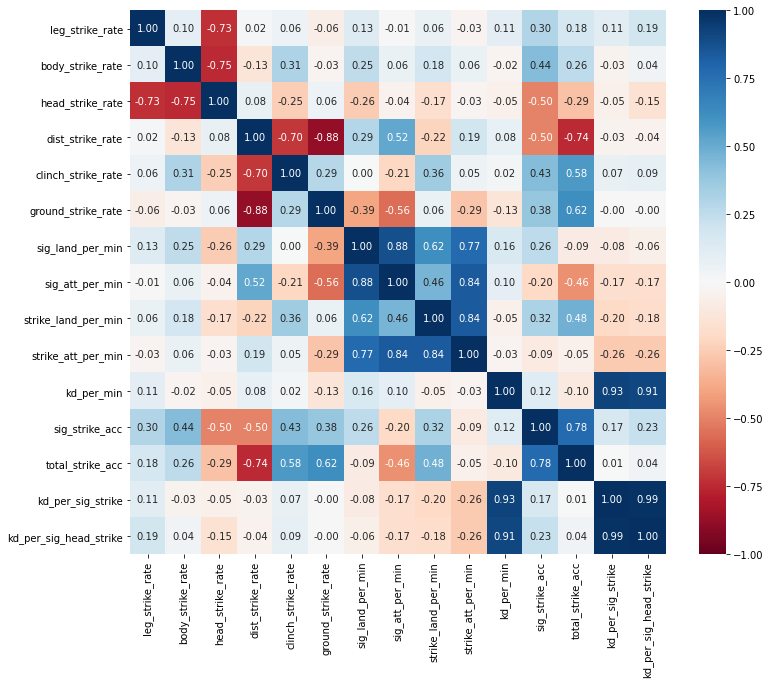

In [43]:
# Striking volume and success
corr_cols = cluster_striking_volume_and_split + cluster_striking_success
show_heatmap(cluster_metrics, corr_cols)

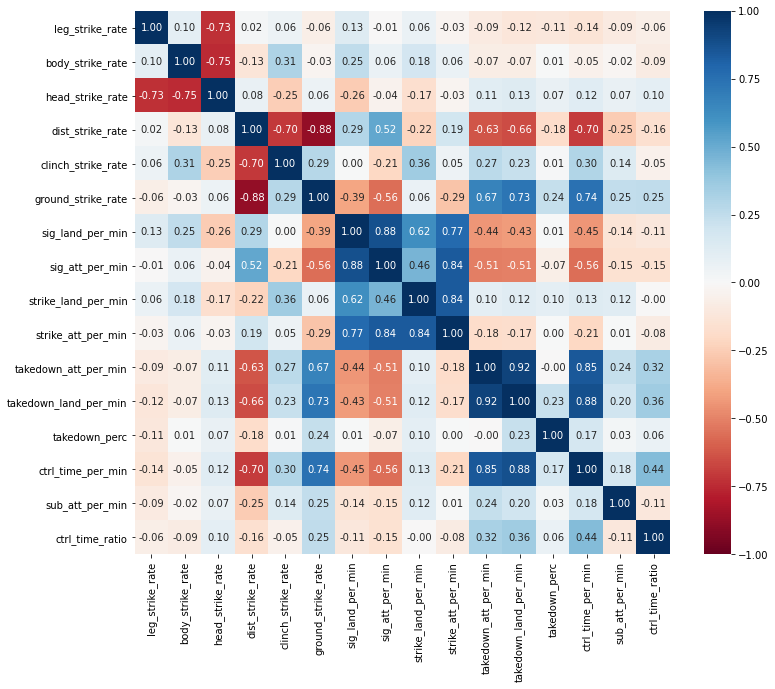

In [44]:
# Striking choices and grappling offense
corr_cols = cluster_striking_volume_and_split + cluster_grappling_offense
show_heatmap(cluster_metrics, corr_cols)

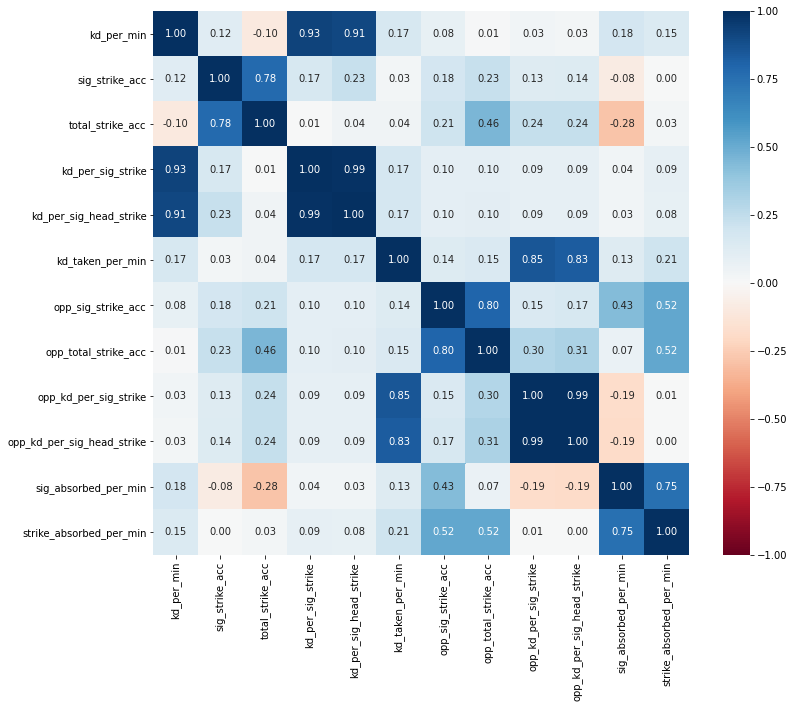

In [45]:
# Striking success, fighter and opponent
corr_cols = cluster_striking_success + cluster_opp_striking_success
show_heatmap(cluster_metrics, corr_cols)

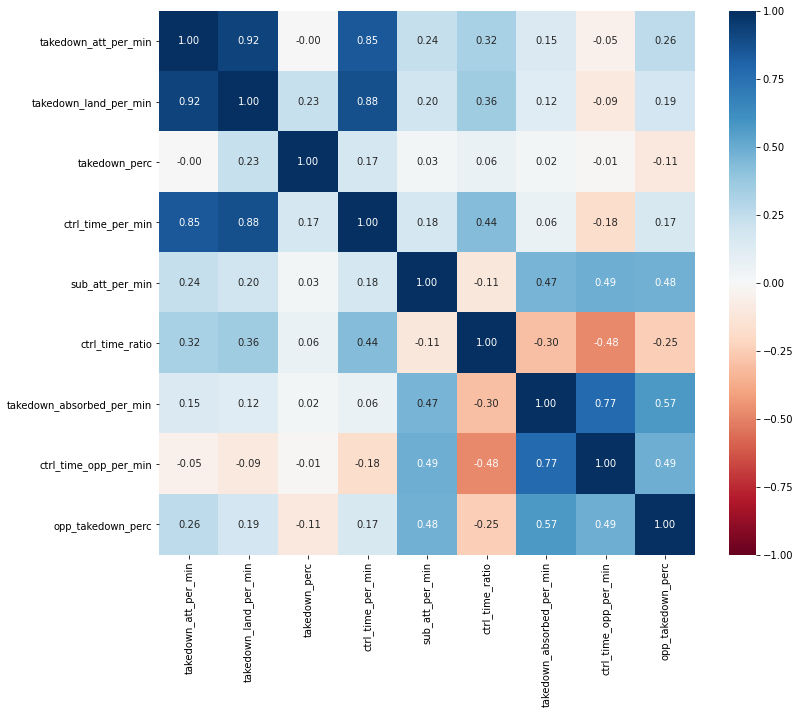

In [46]:
# Grappling offense and defense
corr_cols = cluster_grappling_offense + cluster_grappling_defense
show_heatmap(cluster_metrics, corr_cols)

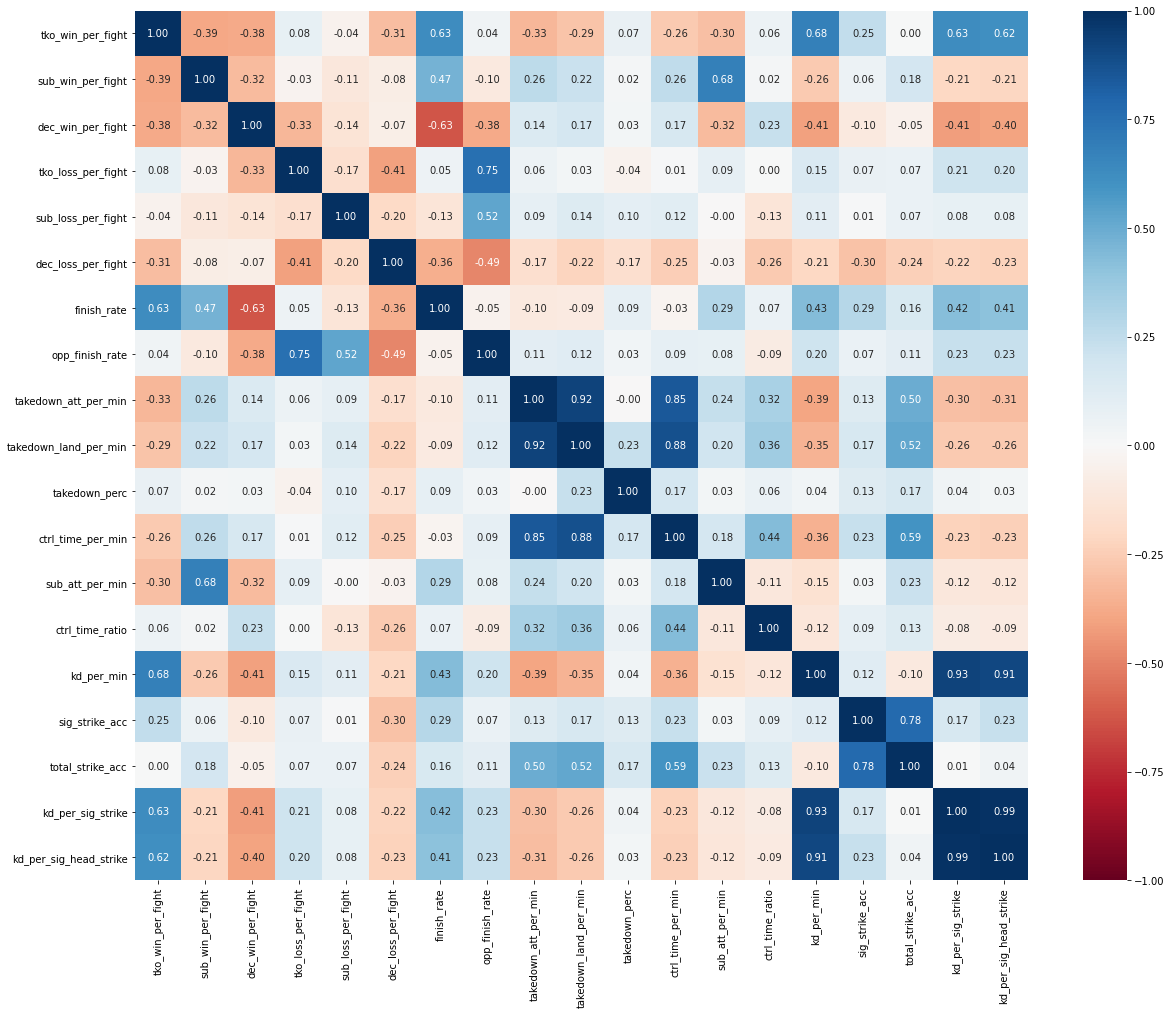

In [47]:
# Finish rate, grappling offense, and striking success
corr_cols = cluster_finishes + cluster_grappling_offense + cluster_striking_success
show_heatmap(cluster_metrics, corr_cols, (20,16))

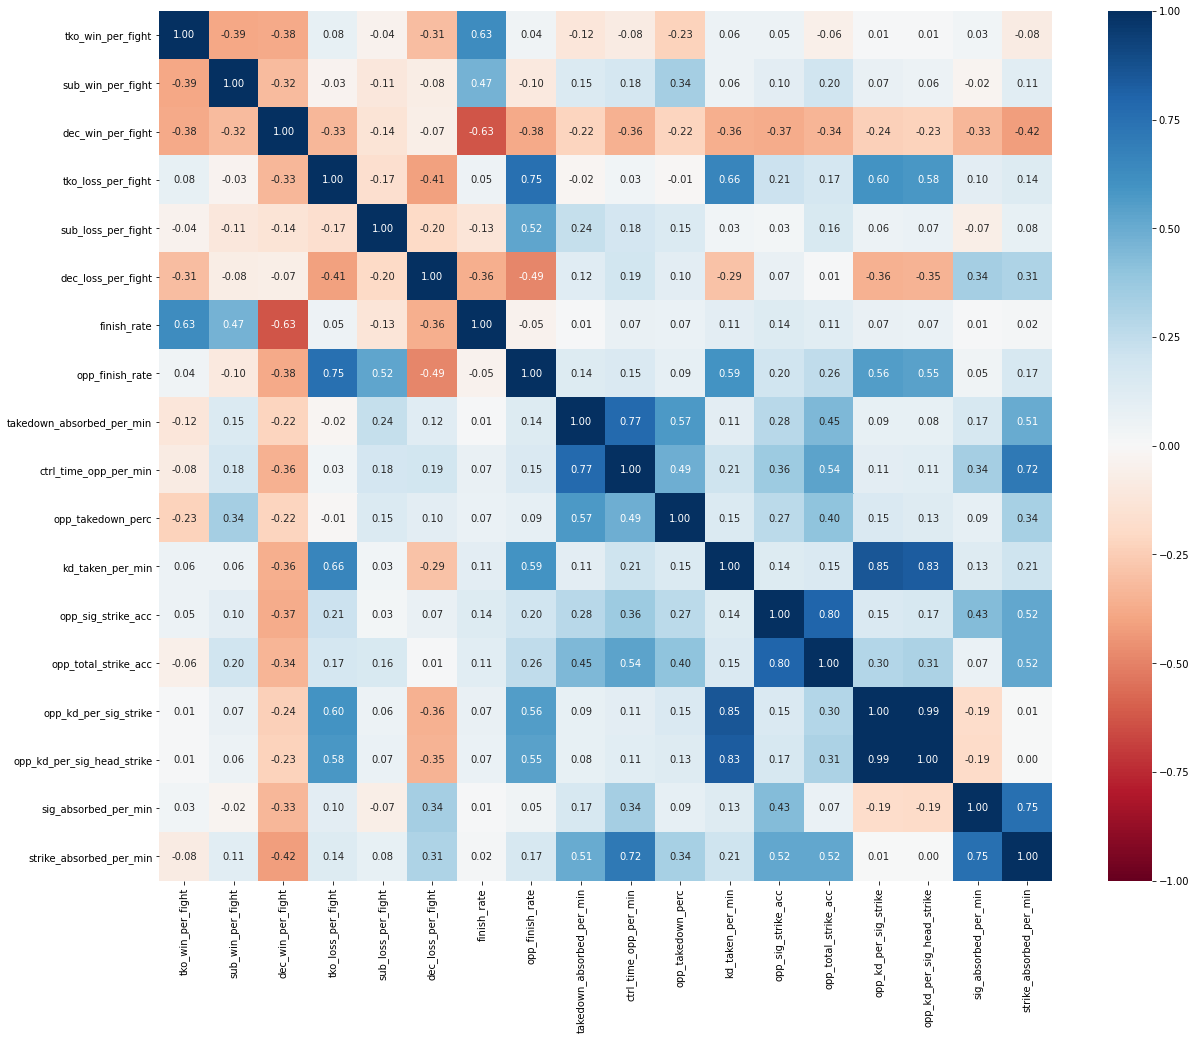

In [48]:
# Finish rate, grappling defense, and opponent striking success
corr_cols = cluster_finishes + cluster_grappling_defense + cluster_opp_striking_success
show_heatmap(cluster_metrics, corr_cols, (20,16))

In [49]:
cluster_metrics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 403 entries, 0 to 407
Data columns (total 53 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   fighter_id                  403 non-null    object 
 1   num_fights                  403 non-null    int64  
 2   tko_win_per_fight           403 non-null    float64
 3   sub_win_per_fight           403 non-null    float64
 4   dec_win_per_fight           403 non-null    float64
 5   tko_win_per_win             403 non-null    float64
 6   sub_win_per_win             403 non-null    float64
 7   dec_win_per_win             403 non-null    float64
 8   tko_loss_per_fight          403 non-null    float64
 9   sub_loss_per_fight          403 non-null    float64
 10  dec_loss_per_fight          403 non-null    float64
 11  tko_loss_per_loss           399 non-null    float64
 12  sub_loss_per_loss           399 non-null    float64
 13  dec_loss_per_loss           399 non

In [50]:
# Replace null and infinity with zero
cluster_metrics.fillna(0, inplace=True)
cluster_metrics.replace([np.inf, -np.inf], 0, inplace=True)

## Variance Inflation Factor - Feature Reduction

In [51]:
def vif_calc(df, cols):
    X = sm.tools.add_constant(df[cols])
    vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
    display(vif)

In [52]:
vif_calc(cluster_metrics, cluster_finishes)

const                 1544.479848
tko_win_per_fight             inf
sub_win_per_fight             inf
dec_win_per_fight       35.255196
tko_loss_per_fight            inf
sub_loss_per_fight            inf
dec_loss_per_fight      25.364123
finish_rate                   inf
opp_finish_rate               inf
dtype: float64

In [53]:
cluster_finishes_subset = ['finish_rate', 'opp_finish_rate', 'tko_win_per_fight']
vif_calc(cluster_metrics, cluster_finishes_subset)

const                8.731898
finish_rate          1.665188
opp_finish_rate      1.010413
tko_win_per_fight    1.664520
dtype: float64

In [54]:
vif_calc(cluster_metrics, cluster_striking_volume_and_split)

const                    0.000000
leg_strike_rate               inf
body_strike_rate              inf
head_strike_rate              inf
dist_strike_rate              inf
clinch_strike_rate            inf
ground_strike_rate            inf
sig_land_per_min       130.376809
sig_att_per_min        475.764825
strike_land_per_min    274.019547
strike_att_per_min     545.434164
dtype: float64

In [55]:
cluster_striking_volume_and_split_subset = ['head_strike_rate', 'dist_strike_rate', 'sig_att_per_min']
vif_calc(cluster_metrics, cluster_striking_volume_and_split_subset)

const               150.706157
head_strike_rate      1.014898
dist_strike_rate      1.384669
sig_att_per_min       1.378374
dtype: float64

In [56]:
vif_calc(cluster_metrics, cluster_striking_success)

const                     64.939865
kd_per_min                 8.299696
sig_strike_acc             3.300955
total_strike_acc           3.014924
kd_per_sig_strike         73.721331
kd_per_sig_head_strike    64.241123
dtype: float64

In [57]:
cluster_striking_success_subset = ['kd_per_min', 'kd_per_sig_strike', 'sig_strike_acc', 'total_strike_acc']
vif_calc(cluster_metrics, cluster_striking_success_subset)

const                56.297456
kd_per_min            8.197790
kd_per_sig_strike     7.870443
sig_strike_acc        2.813262
total_strike_acc      2.936223
dtype: float64

In [58]:
vif_calc(cluster_metrics, cluster_opp_striking_success)

const                         97.793317
kd_taken_per_min               6.610124
opp_sig_strike_acc            12.544435
opp_total_strike_acc          20.105773
opp_kd_per_sig_strike         85.716527
opp_kd_per_sig_head_strike    73.144588
sig_absorbed_per_min          14.946067
strike_absorbed_per_min       13.688105
dtype: float64

In [59]:
cluster_opp_striking_success_subset = ['opp_kd_per_sig_strike', 'opp_sig_strike_acc', 'opp_total_strike_acc', 'sig_absorbed_per_min']
vif_calc(cluster_metrics, cluster_opp_striking_success_subset)

const                    55.604135
opp_kd_per_sig_strike     1.151856
opp_sig_strike_acc        4.520185
opp_total_strike_acc      3.826540
sig_absorbed_per_min      1.695840
dtype: float64

In [60]:
vif_calc(cluster_metrics, cluster_grappling_offense)

const                    16.223197
takedown_att_per_min     11.102097
takedown_land_per_min    12.532128
takedown_perc             1.612454
ctrl_time_per_min         5.008228
sub_att_per_min           1.118527
ctrl_time_ratio           1.302502
dtype: float64

In [61]:
cluster_grappling_offense_subset = ['takedown_land_per_min', 'ctrl_time_per_min', 'sub_att_per_min', 'ctrl_time_ratio']
vif_calc(cluster_metrics, cluster_grappling_offense_subset)

const                    5.653434
takedown_land_per_min    4.433603
ctrl_time_per_min        4.765598
sub_att_per_min          1.089422
ctrl_time_ratio          1.298067
dtype: float64

In [62]:
vif_calc(cluster_metrics, cluster_grappling_defense)

const                        7.329222
takedown_absorbed_per_min    2.853631
ctrl_time_opp_per_min        2.516188
opp_takedown_perc            1.495421
dtype: float64

In [63]:
cluster_grappling_defense_subset = cluster_grappling_defense.copy()
vif_calc(cluster_metrics, cluster_grappling_defense_subset)

const                        7.329222
takedown_absorbed_per_min    2.853631
ctrl_time_opp_per_min        2.516188
opp_takedown_perc            1.495421
dtype: float64

In [64]:
cluster_subset = cluster_finishes_subset + cluster_striking_volume_and_split_subset + cluster_striking_success_subset\
                 + cluster_opp_striking_success_subset + cluster_grappling_offense_subset + cluster_grappling_defense_subset

In [65]:
vif_calc(cluster_metrics, cluster_subset)

const                        1067.090650
finish_rate                     3.616574
opp_finish_rate                 1.750248
tko_win_per_fight               4.877532
head_strike_rate                1.736710
dist_strike_rate                4.744210
sig_att_per_min                 3.651450
kd_per_min                     16.361245
kd_per_sig_strike              16.480688
sig_strike_acc                  5.391181
total_strike_acc                7.356926
opp_kd_per_sig_strike           1.843656
opp_sig_strike_acc              6.492751
opp_total_strike_acc            9.278594
sig_absorbed_per_min            3.742877
takedown_land_per_min           5.088379
ctrl_time_per_min               9.203966
sub_att_per_min                 2.970403
ctrl_time_ratio                 1.718836
takedown_absorbed_per_min       3.576735
ctrl_time_opp_per_min           5.918964
opp_takedown_perc               1.857861
dtype: float64

In [66]:
cluster_subset.remove('kd_per_min')
cluster_subset.remove('ctrl_time_ratio')
cluster_subset.remove('ctrl_time_opp_per_min')
cluster_subset.remove('opp_total_strike_acc')

vif_calc(cluster_metrics, cluster_subset)

const                        1013.703823
finish_rate                     3.571372
opp_finish_rate                 1.745154
tko_win_per_fight               4.631070
head_strike_rate                1.727626
dist_strike_rate                4.522156
sig_att_per_min                 2.585011
kd_per_sig_strike               2.241496
sig_strike_acc                  5.035591
total_strike_acc                6.633371
opp_kd_per_sig_strike           1.828710
opp_sig_strike_acc              1.900889
sig_absorbed_per_min            3.497487
takedown_land_per_min           4.848197
ctrl_time_per_min               7.166485
sub_att_per_min                 2.823133
takedown_absorbed_per_min       2.462887
opp_takedown_perc               1.772819
dtype: float64

In [67]:
# Remove finishing metrics

cluster_subset.remove('finish_rate')
cluster_subset.remove('opp_finish_rate')
cluster_subset.remove('tko_win_per_fight')

vif_calc(cluster_metrics, cluster_subset)

const                        964.388887
head_strike_rate               1.582300
dist_strike_rate               4.200856
sig_att_per_min                2.329777
kd_per_sig_strike              1.441483
sig_strike_acc                 4.629215
total_strike_acc               6.533829
opp_kd_per_sig_strike          1.330240
opp_sig_strike_acc             1.856925
sig_absorbed_per_min           3.201228
takedown_land_per_min          4.800070
ctrl_time_per_min              6.858425
sub_att_per_min                1.555672
takedown_absorbed_per_min      2.379360
opp_takedown_perc              1.749702
dtype: float64

## Transform Data for Clustering

#### *Filter and Scale Cluster Data*

In [68]:
# Filter data to subset of cluster columns based on VIF
cluster_data = cluster_metrics[cluster_subset].copy()

In [69]:
# Standard scale the data
st_scale = StandardScaler()
cluster_data_st = st_scale.fit_transform(cluster_data)

In [70]:
# Pickle the scaler for future transformations
with open('nf_standard_scaler_fighter_style.pickle', 'wb') as to_write:
    pickle.dump(st_scale, to_write)

#### *Determine Optimal PCA Components*

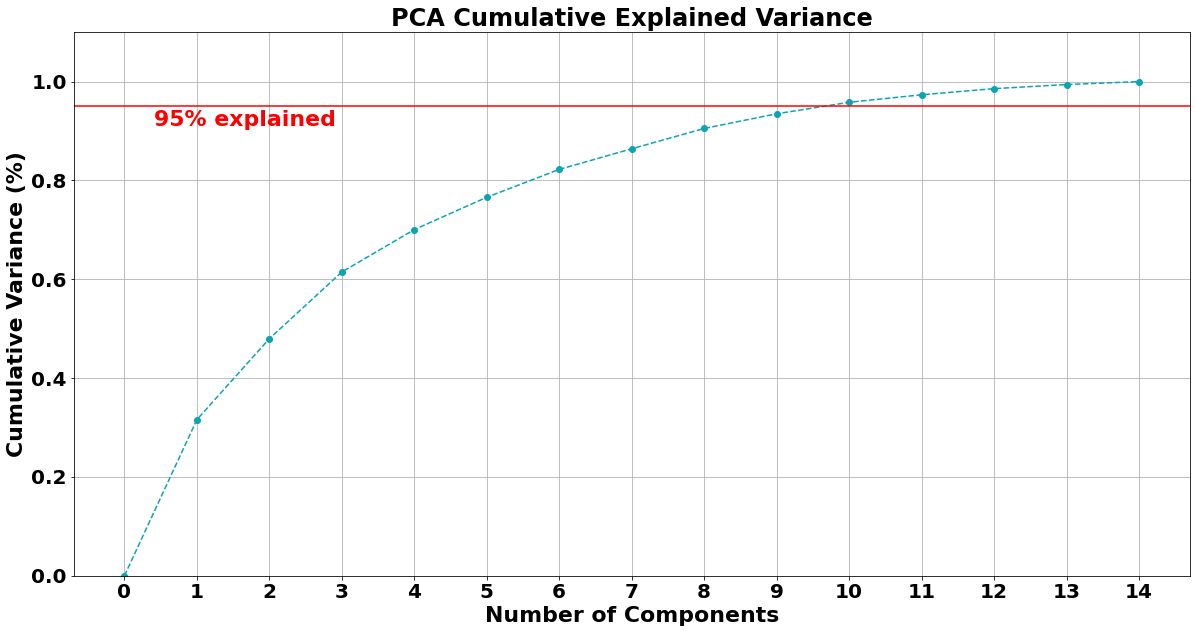

In [71]:
# Set random state variable
rs = 13

# Determine number of PCA components
pca = PCA(len(cluster_subset), random_state=rs).fit(cluster_data_st) # include number of features for test

# Plot PCA components and cumulative explained variance
fig, ax = plt.subplots(figsize=(20, 10))
x = np.arange(0, len(cluster_subset) + 1, step=1)
y = np.cumsum(np.insert(pca.explained_variance_ratio_, 0, 0))

plt.ylim(0.0,1.1)
plt.plot(x, y, marker='o', linestyle='--', color='#0AA4B2')

plt.xlabel('Number of Components', fontsize=22, color='black', fontweight='bold')
plt.xticks(np.arange(0, len(cluster_subset) + 1, step=1), fontsize=20, color='black', fontweight='bold') #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative Variance (%)', fontsize=22, color='black', fontweight='bold')
plt.yticks(fontsize=20, color='black', fontweight='bold')
plt.title('PCA Cumulative Explained Variance', fontsize=24, fontweight='bold')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.41, 0.91, '95% explained', color = 'red', fontsize=22, fontweight='bold')

ax.grid(axis='x')
ax.grid(axis='y')
#fig.savefig('pca_variance.png')
plt.show()


In [72]:
# Display variance explained in a dataframe
pd.DataFrame({'Components' : x, 'Cum. Variance' : y}).sort_values('Components', ascending=False)

,Components,Cum. Variance
14,14,1.000000
13,13,0.994087
12,12,0.985799
11,11,0.973376
10,10,0.958154
9,9,0.934927
8,8,0.905185
7,7,0.864087
6,6,0.822312
5,5,0.765983


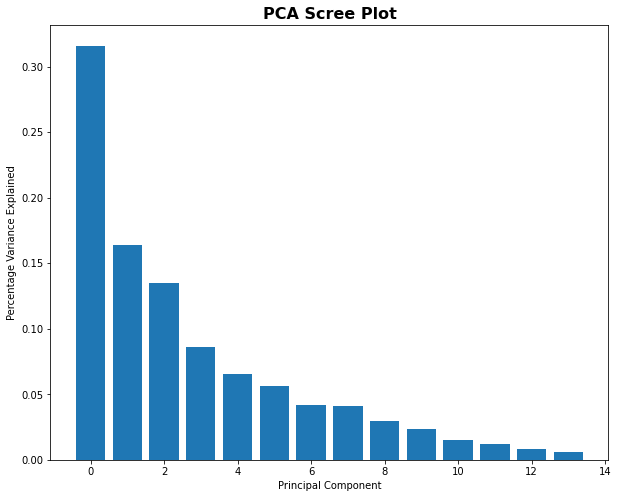

In [73]:
# Display Scree plot
fig, ax = plt.subplots(figsize=(10,8))
x = np.arange(0, len(cluster_subset), step=1)
y = pca.explained_variance_ratio_

plt.bar(x, y)
plt.title('PCA Scree Plot', fontsize=16, fontweight='bold')
plt.xlabel('Principal Component')
plt.ylabel('Percentage Variance Explained')
plt.show()

In [74]:
# Display variance explained in a dataframe
pd.DataFrame({'Components' : x, 'Variance Explained' : y}).sort_values('Components')

,Components,Variance Explained
0,0,0.315992
1,1,0.163822
2,2,0.134915
3,3,0.085836
4,4,0.065418
5,5,0.056329
6,6,0.041776
7,7,0.041097
8,8,0.029743
9,9,0.023227


#### *Run PCA Transformation (10 components - 95% explained)*

In [75]:
# Rebuild PCA witth chosen number of components
pca = PCA(10, random_state=rs)

# Transform the clustering data
cluster_data_pca = pca.fit_transform(cluster_data_st)

In [76]:
# Pickle the PCA for new transformations and predictions
with open('nf_pca_fighter_style.pickle', 'wb') as to_write:
    pickle.dump(pca, to_write)

## Clustering Functions and Dictionaries

### *Functions*

In [77]:
def plot_3d_scatter(pca_data, y_predicted, title, exclude=[]):
    """
    Plot 3D scatters for a given set of PCA data and fighter clusters (y-predicted).
    """

    if exclude:
        m = np.invert(np.isin(y_predicted, exclude))
        pca_data = pca_data[m]
        y_predicted = y_predicted[m]
    
    x = pca_data[:, 0]
    y = pca_data[:, 1]
    z = pca_data[:, 2]
    
    plt.style.use('default')
    
    fig, axes = plt.subplots(1, 4, figsize=[28, 10])
    #fig.tight_layout(pad=3.0)
    #fig.subplots_adjust(top=0.9)
    
    subtitles = ['', ' - Rotated 90', ' - Rotated 180', ' - Rotated 270']
    
    for i in range(0,4):
        ax = plt.subplot(1, 4, i + 1, projection='3d')
        ax.plot(z, x, y, linestyle='none', marker='o', alpha=0.25)
        ax.scatter(z, x, y, c=pd.Series(y_predicted).map(colors))
        ax.set_xlabel('PC3', fontsize=12)
        ax.set_ylabel('PC1', fontsize=12)
        ax.set_zlabel('PC2', fontsize=12)
        ax.axes.set_xlim3d(left=z.min(), right=z.max()) 
        ax.axes.set_ylim3d(bottom=x.min(), top=x.max()) 
        ax.axes.set_zlim3d(bottom=y.min(), top=y.max()) 
        ax.view_init(elev=10, azim=10 + i * 180)
        ax.set_title(title + subtitles[i], fontsize=14, fontweight='bold')

    fig.tight_layout()

In [78]:
def metric_distributions_by_cluster(cluster_data, category):
    """
    Plot fight metric distributions by cluster.
    """
    
    metric_count = len(metric_dict)
    metric_list = list(metric_dict.keys())
    
    fig, axes = plt.subplots(1, metric_count, figsize=[metric_count * 6, 8])
    fig.tight_layout(pad=3.0)
    
    for i in range(0, metric_count):
        ax = plt.subplot(1, metric_count, i + 1)
    
        sns.set_palette(sns.color_palette(list(colors.values())))
        sns.boxplot(data=cluster_data[[metric_list[i], category]], y=category, x=metric_list[i], orient="h")
        
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        
        ax.set_title(metric_dict[metric_list[i]], fontsize=14, fontweight='bold')


In [79]:
def one_vs_rest_box(data, cluster_col, cluster_val, viz_cols, title):
    """
    Accept a dataset (cluster column LAST) and a cluster value.
    Display one vs. rest distributions for all metrics in the data.
    """
    
    cols = data.columns[:-1]
    viz_rows = ceil(len(cols) / viz_cols)
    title = title + ' - Cluster ' + str(cluster_val) + ' - One vs. Rest'
    
    data[cluster_col] = np.where(data[cluster_col] == cluster_val, str(cluster_val), 'REST')
    data.sort_values(cluster_col, ascending=False, inplace=True)
    
    fig, axes = plt.subplots(viz_rows, viz_cols, figsize=[viz_cols * 4, viz_rows * 3])
    fig.tight_layout(pad=5.0)
    fig.suptitle(title, fontsize=22, fontweight='bold')
    fig.subplots_adjust(top=0.9)
    
    sns.set_palette(sns.color_palette('tab10'))
    
    for i in range(len(cols)):
        plt.subplot(viz_rows, viz_cols, i + 1)
        box = sns.boxplot(data=data, x=cols[i], y=cluster_col, orient="h")
        box.set(xlabel=None, ylabel=None)
        plt.title(metric_dict[cols[i]])
    
    plt.savefig(title+'.png')

In [80]:
def plot_dendrogram(model, **kwargs):
    """
    Plot dendrogram of HAC for determining number of clusters.
    """
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)

### *Dictionaries*

In [81]:
# Color dictionary for up to 10 clusters
colors = {0 : 'red',
          1 : 'green',
          2 : 'blue',
          3 : 'purple',
          4 : 'orange',
          5 : 'aqua',
          6 : 'pink',
          7 : 'fuchsia',
          8 : 'brown',
          9 : 'gray'
         }

In [82]:
# Titles for each fight metric
metric_dict = {#'finish_rate' : 'Finish Rate',
               #'opp_finish_rate' : 'Opp Finish Rate',
               #'tko_win_per_fight' : 'TKO Rate',
               'head_strike_rate' : 'Head Strike Perc',
               'dist_strike_rate' : 'Dist Strike Perc',
               'sig_att_per_min' : 'Sig Att Per Min',
               'kd_per_sig_strike' : 'KD Per Sig Strike',
               'sig_strike_acc' : 'Sig Strike Acc',
               'total_strike_acc' : 'Total Strike Acc',
               'opp_kd_per_sig_strike' : 'Opp KD Per Sig Strike',
               'opp_sig_strike_acc' : 'Opp Sig Strike Acc',
               'sig_absorbed_per_min' : 'Sig Strike Absorbed Per Min',
               #'opp_total_strike_acc' : 'Opp Total Strike Acc',
               'takedown_land_per_min' : 'Takedown Landed Per Min',
               'ctrl_time_per_min' : 'Control Time Per Min',
               'sub_att_per_min' : 'Sub Att Per Min',
               #'ctrl_time_ratio' : 'Control Time Ratio',
               'takedown_absorbed_per_min' : 'Takedown Absorbed Per Min',
               #'ctrl_time_opp_per_min' : 'Opp Control Time Per Min',
               'opp_takedown_perc' : 'Opp Takedown Success Rate',
               #'opp_sub_success_rate': 'Opp Sub Success Rate'
               }

## K-Means Clustering

#### *Choose Number of K-Means Clusters*

Clusters =  2 :  Silhouette Score =  0.22938930495723858
Clusters =  3 :  Silhouette Score =  0.19223450683637974
Clusters =  4 :  Silhouette Score =  0.13945280576278468
Clusters =  5 :  Silhouette Score =  0.12632164634523257
Clusters =  6 :  Silhouette Score =  0.1358532036229147
Clusters =  7 :  Silhouette Score =  0.11178738972136759
Clusters =  8 :  Silhouette Score =  0.11237194736500329
Clusters =  9 :  Silhouette Score =  0.1000210671528979
Clusters =  10 :  Silhouette Score =  0.0996614542716406
Clusters =  11 :  Silhouette Score =  0.10645471598035547
Clusters =  12 :  Silhouette Score =  0.11235538172959124
Clusters =  13 :  Silhouette Score =  0.11132881913597135
Clusters =  14 :  Silhouette Score =  0.11482383567355524
Clusters =  15 :  Silhouette Score =  0.0985876244105949
Clusters =  16 :  Silhouette Score =  0.09689462005413799
Clusters =  17 :  Silhouette Score =  0.10662552194588264
Clusters =  18 :  Silhouette Score =  0.10757221393568744
Clusters =  19 :  Silhouet

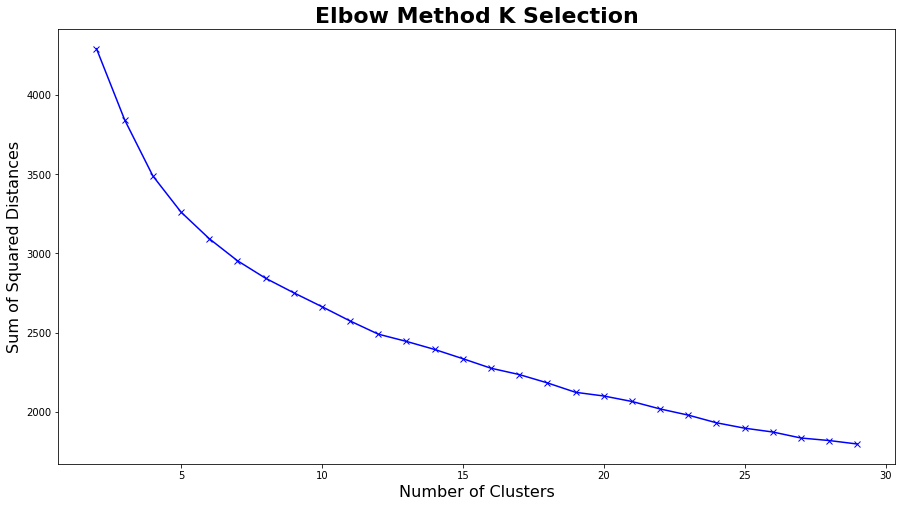

In [83]:
sum_of_squared_distances = []
for i in range(2,30):
    km = KMeans(n_clusters=i, random_state=rs)
    prediction = km.fit_predict(cluster_data_pca)
    
    silhouette = silhouette_score(cluster_data_pca, prediction, random_state=rs)
    print ('Clusters = ', i, ':  Silhouette Score = ', silhouette)
    
    sum_of_squared_distances.append(km.inertia_)

fig = plt.figure(figsize=(15, 8))
plt.plot(range(2,30), sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters', fontsize=16)
plt.ylabel('Sum of Squared Distances', fontsize=16)
plt.title('Elbow Method K Selection', fontsize=22, fontweight='bold')
plt.show()

#### *Generate K-Means Clusters (K=10)*

In [84]:
# Create K-Means model and make predictions
km = KMeans(n_clusters=10, random_state=rs)
y_predicted = km.fit_predict(cluster_data_pca)

In [85]:
# Set heatmap
cm = sns.color_palette('RdYlGn', as_cmap=True)

# Add predictions to the data and show mean for each cluster and feature combination
cluster_data_km_10 = cluster_data.copy(deep=True)
cluster_data_km_10['cluster_kmeans_10'] = y_predicted
cluster_data_km_10.groupby('cluster_kmeans_10').mean().style.background_gradient(cmap=cm)

,head_strike_rate,dist_strike_rate,sig_att_per_min,kd_per_sig_strike,sig_strike_acc,total_strike_acc,opp_kd_per_sig_strike,opp_sig_strike_acc,sig_absorbed_per_min,takedown_land_per_min,ctrl_time_per_min,sub_att_per_min,takedown_absorbed_per_min,opp_takedown_perc
cluster_kmeans_10,,,,,,,,,,,,,,
0,0.829201,0.785922,10.161421,0.003015,0.413889,0.517316,0.004228,0.474171,5.404917,0.173836,11.434183,0.170626,0.378646,0.586126
1,0.774407,0.761536,8.052400,0.009877,0.467178,0.532882,0.003949,0.443609,3.740846,0.090124,8.508951,0.025016,0.152858,0.313353
2,0.790028,0.889713,11.528328,0.003450,0.397679,0.444505,0.002833,0.394632,4.035050,0.082232,6.694280,0.021805,0.112209,0.280254
3,0.833373,0.669245,6.722389,0.001431,0.437305,0.591993,0.003434,0.452935,3.172599,0.554902,23.785402,0.092791,0.245393,0.544508
4,0.864340,0.820152,8.807324,0.002173,0.381975,0.479698,0.002776,0.414701,3.748417,0.267029,16.329738,0.046920,0.106835,0.325573
5,0.694451,0.613608,8.363981,0.004735,0.545055,0.656964,0.004765,0.496165,4.097635,0.273051,17.417211,0.083537,0.292713,0.422124
6,0.772070,0.876973,13.543087,0.002932,0.454372,0.499993,0.001249,0.452787,5.705370,0.063711,6.692734,0.031282,0.126630,0.303248
7,0.744588,0.794443,10.317612,0.002210,0.467697,0.551823,0.002121,0.435161,4.210739,0.152027,11.805692,0.050825,0.219669,0.403275
8,0.795699,0.504916,6.381573,0.002424,0.524196,0.686004,0.009235,0.427791,2.039386,0.809642,30.891999,0.068888,0.214796,0.422319


In [86]:
# Add fighter_id column to the cluster_data table
cluster_data_km_10['fighter_id'] = cluster_metrics['fighter_id']

In [87]:
# Show cluster counts
cluster_data_km_10[['cluster_kmeans_10']].value_counts().sort_values()

cluster_kmeans_10
8                    17
0                    28
3                    28
5                    28
1                    35
6                    44
4                    45
9                    51
7                    60
2                    67
dtype: int64

In [88]:
# Set up dataframe for closest fighters to each cluster center 
rank = {'Rank': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
closest_to_kmeans_center = pd.DataFrame.from_dict(rank)

for i in range(10):
    # Transform data and get indicies of closest fighters
    d = km.transform(cluster_data_pca)[:, i]
    ind = np.argsort(d)[::][:10]
    
    # Get fighter names, merge to a single column in consolidated dataframe
    closest = cluster_data_km_10.iloc[ind, -1].to_frame().merge(fighter_details[['fighter_id', 'first_name', 'last_name']], on='fighter_id')
    closest_to_kmeans_center['Cluster ' + str(i)] = closest['first_name'] + ' ' + closest['last_name']    

# Display
closest_to_kmeans_center.style.hide_index()

Rank,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9
1,Dan Miller,Dan Henderson,Ross Pearson,Stephan Bonnar,Brandon Moreno,John Howard,Yair Rodriguez,Alexandre Pantoja,Randy Couture,Beneil Dariush
2,Gerald Meerschaert,Hector Lombard,Robert Whittaker,Antonio Carlos Junior,Scott Jorgensen,Chris Leben,Jake Collier,Stevie Ray,Matt Hughes,Jake Matthews
3,Godofredo Pepey,Quinton Jackson,Kelvin Gastelum,Carla Esparza,Omari Akhmedov,Alex Oliveira,Cory Sandhagen,Rafael Dos Anjos,Ricardo Almeida,Rafael Natal
4,Mickey Gall,Thiago Santos,Al Iaquinta,Michael Chiesa,Sam Sicilia,Matt Brown,Lando Vannata,Randy Brown,Mark Munoz,Diego Brandao
5,Nate Diaz,Darren Till,Stephen Thompson,Tito Ortiz,Clay Guida,Devin Clark,Dan Hooker,Brian Kelleher,Ramsey Nijem,Amanda Nunes
6,Jim Miller,Tai Tuivasa,Chad Laprise,CB Dollaway,Anthony Rocco Martin,Josh Barnett,Volkan Oezdemir,Chris Camozzi,Jon Fitch,Leon Edwards
7,Chris Lytle,Eryk Anders,Elizeu Zaleski dos Santos,Darren Elkins,Diego Sanchez,Trevor Smith,Alex White,Miesha Tate,Vladimir Matyushenko,Olivier Aubin-Mercier
8,John Moraga,Tyron Woodley,Brad Tavares,Thiago Tavares,Claudia Gadelha,Ed Herman,Paul Felder,Jorge Masvidal,Matt Lindland,Mike Pierce
9,Chas Skelly,Jeremy Stephens,Alex White,Nik Lentz,Keita Nakamura,Tim Boetsch,Cub Swanson,Jan Blachowicz,Dong Hyun Kim,Krzysztof Jotko
10,Josh Neer,Mirko Filipovic,Li Jingliang,Chris Weidman,Sijara Eubanks,Mark Munoz,Angela Hill,Francisco Trinaldo,Tito Ortiz,Danny Castillo


#### *Visualize K-Means Clusters (K=10)*

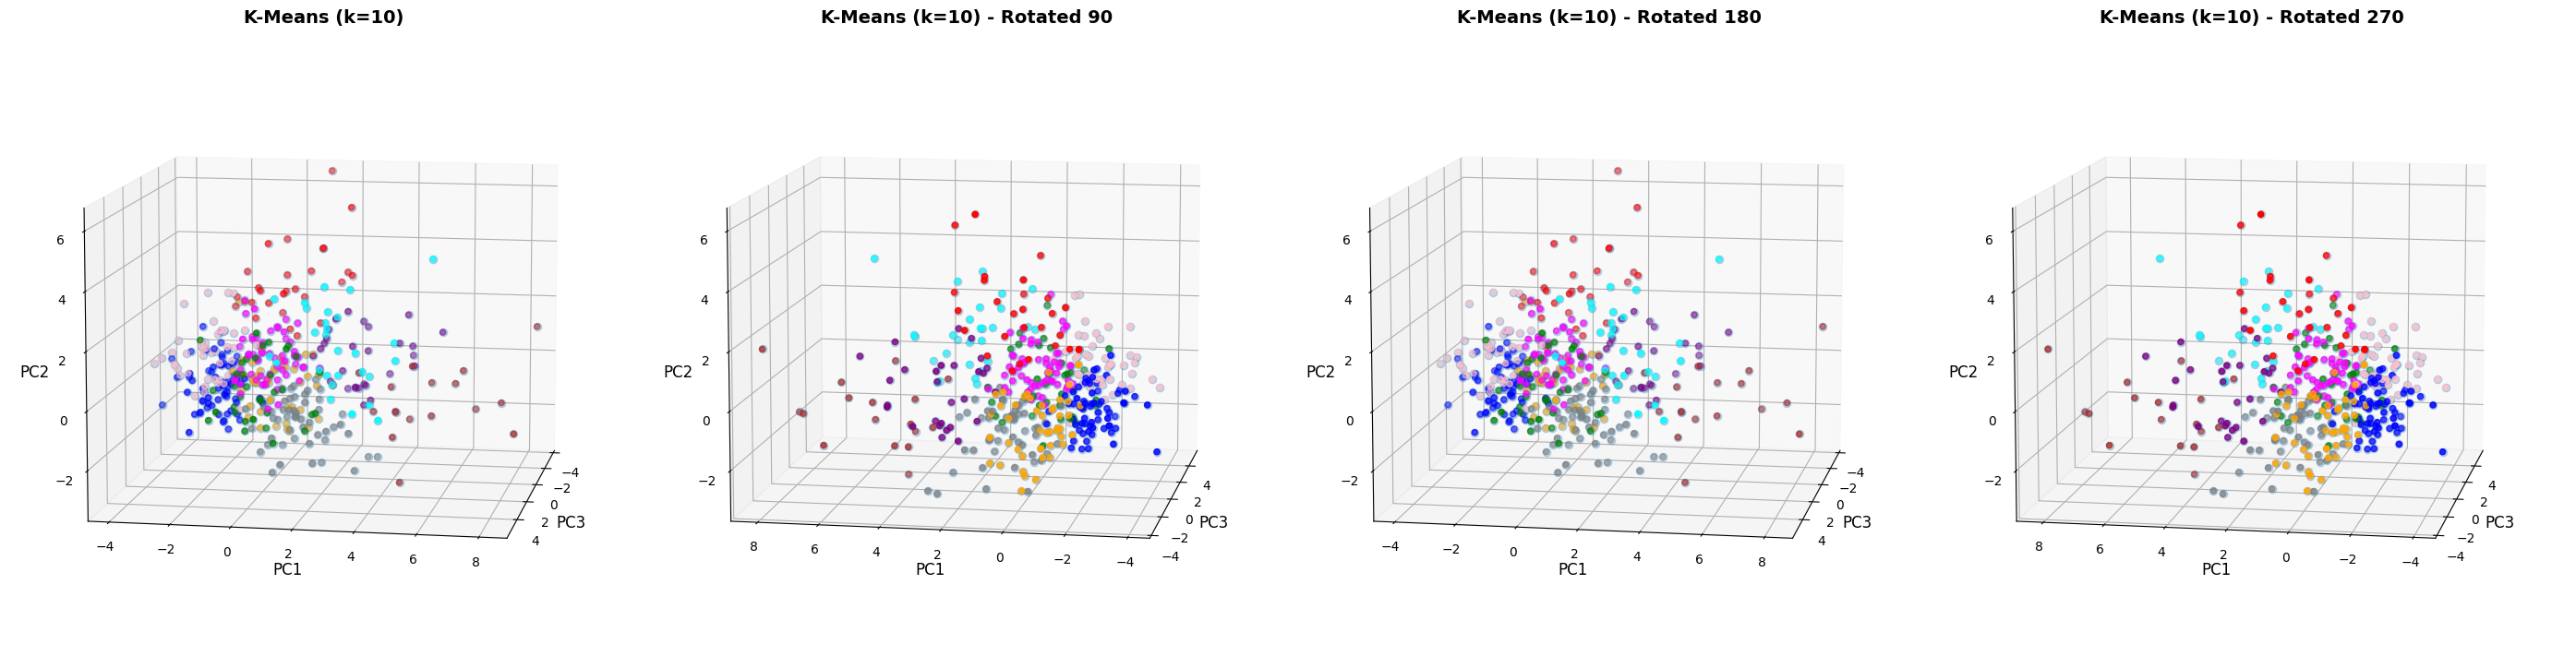

In [89]:
plot_3d_scatter(cluster_data_pca, y_predicted, 'K-Means (k=10)')

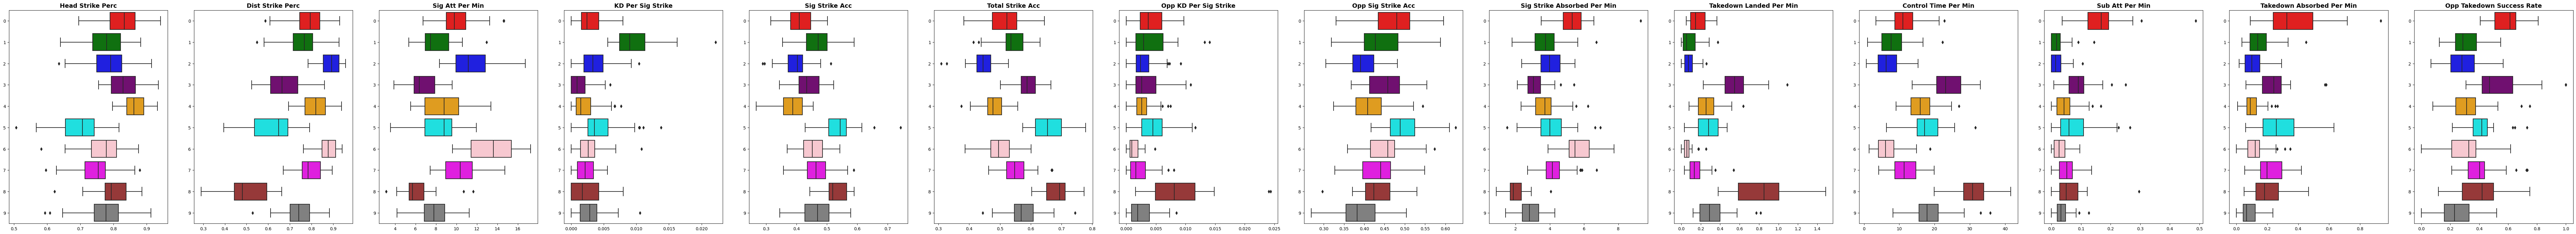

In [90]:
metric_distributions_by_cluster(cluster_data_km_10, 'cluster_kmeans_10')

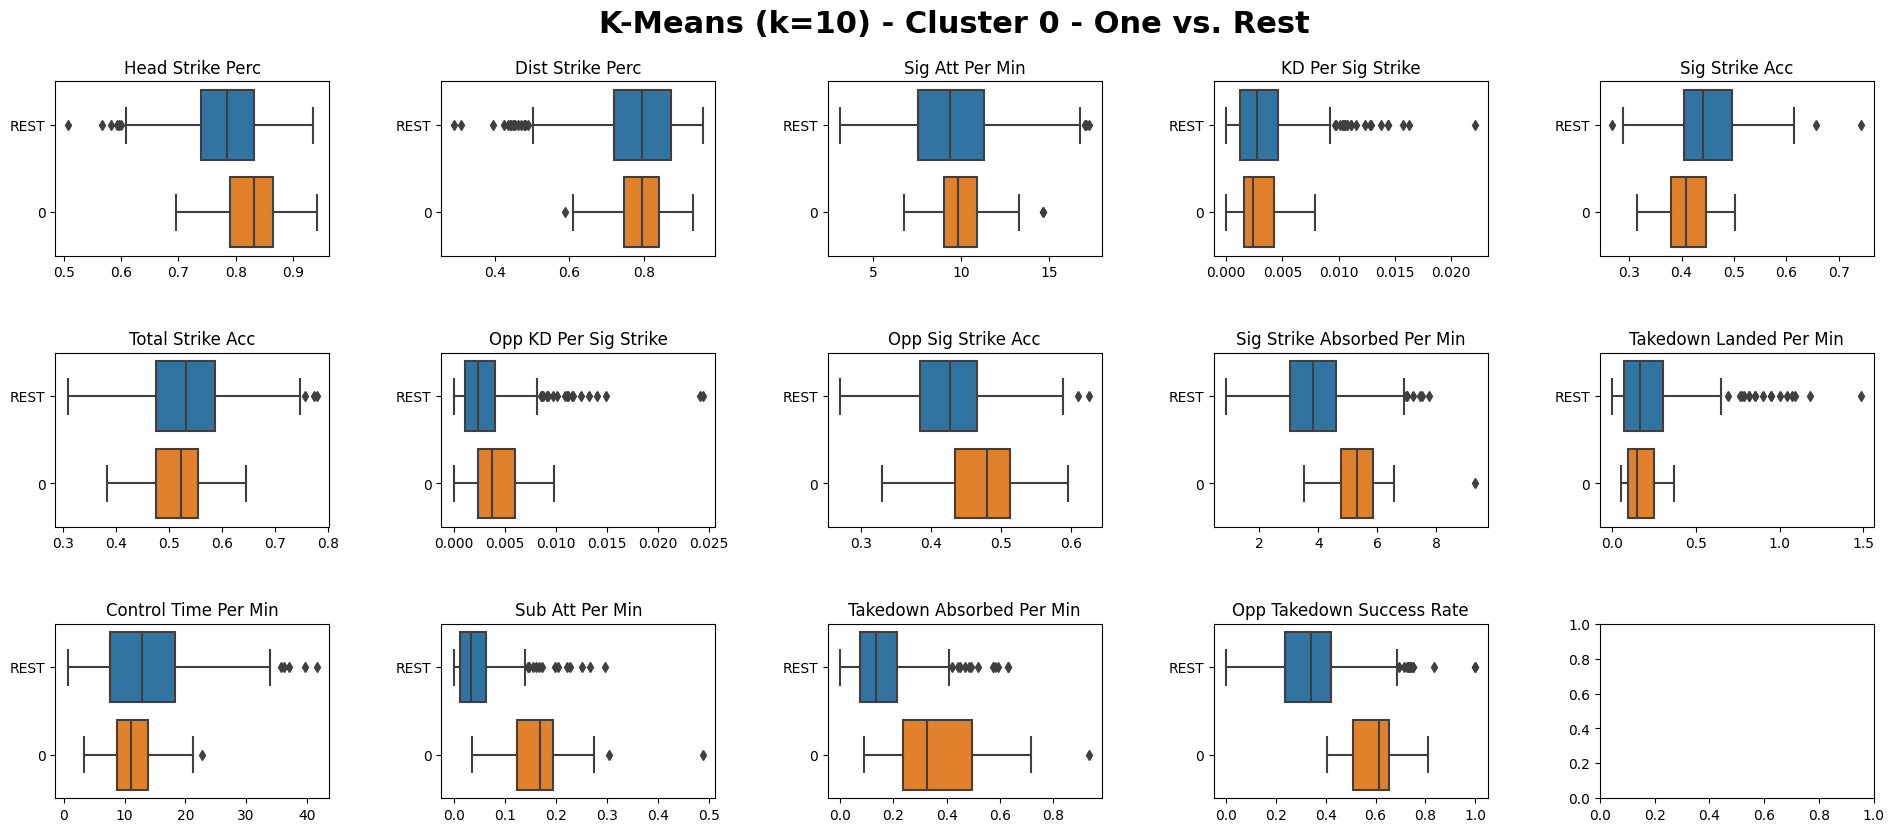

In [91]:
one_vs_rest_box(cluster_data_km_10.iloc[:,0:-1].copy(), 'cluster_kmeans_10', 0, 5, 'K-Means (k=10)')

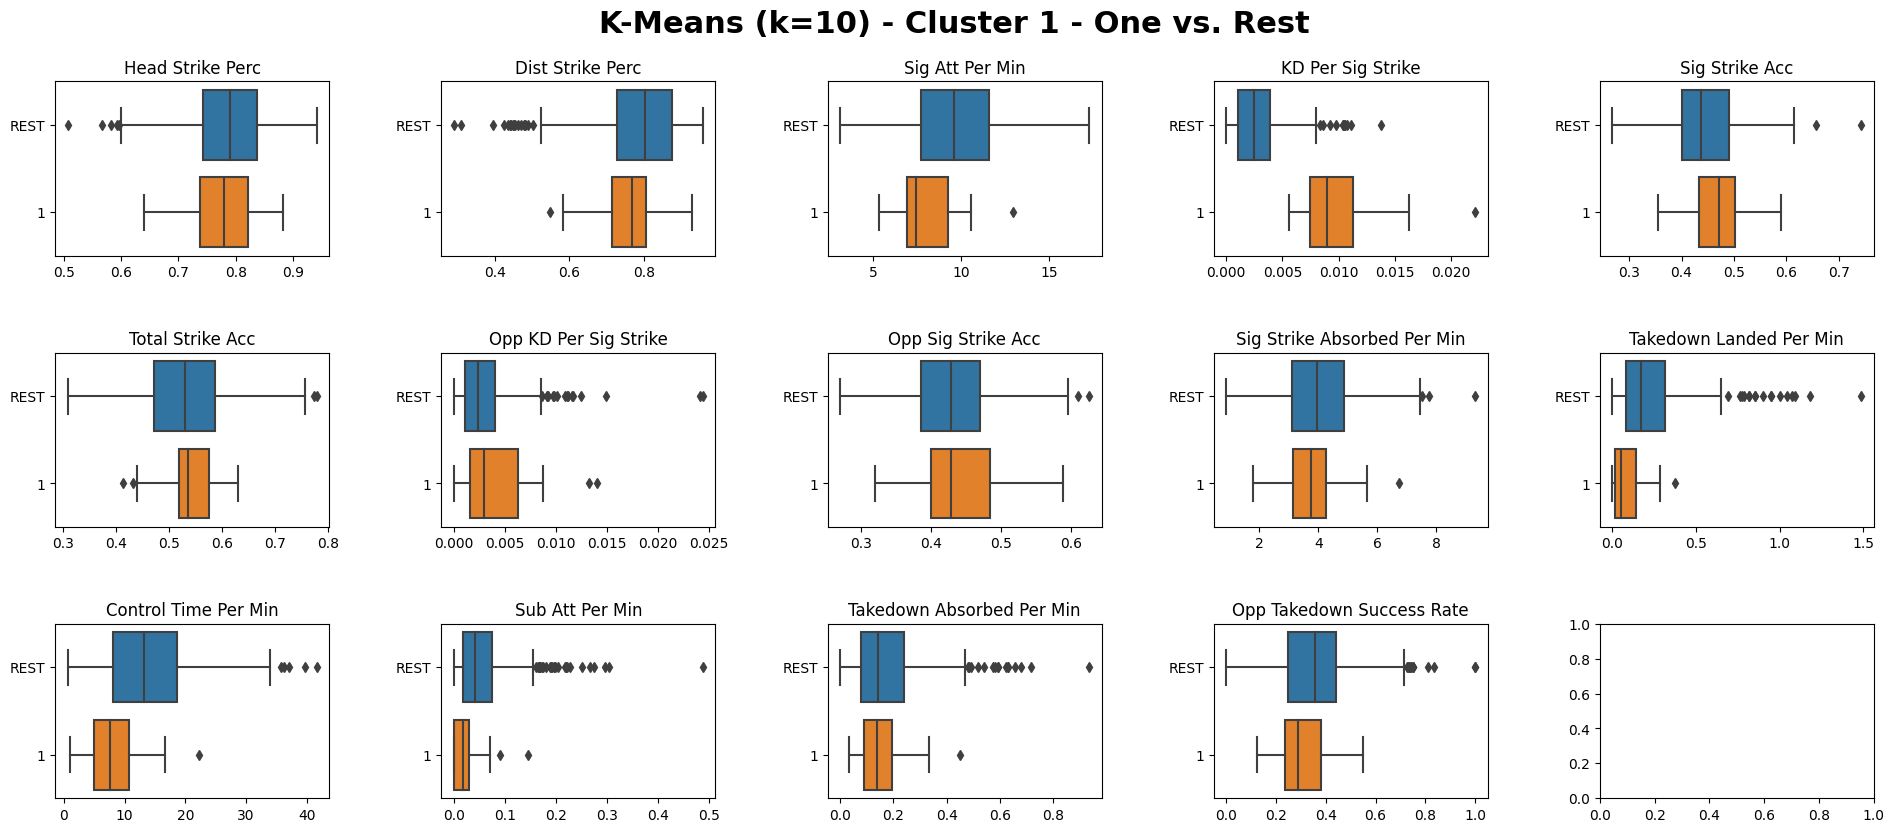

In [92]:
one_vs_rest_box(cluster_data_km_10.iloc[:,0:-1].copy(), 'cluster_kmeans_10', 1, 5, 'K-Means (k=10)')

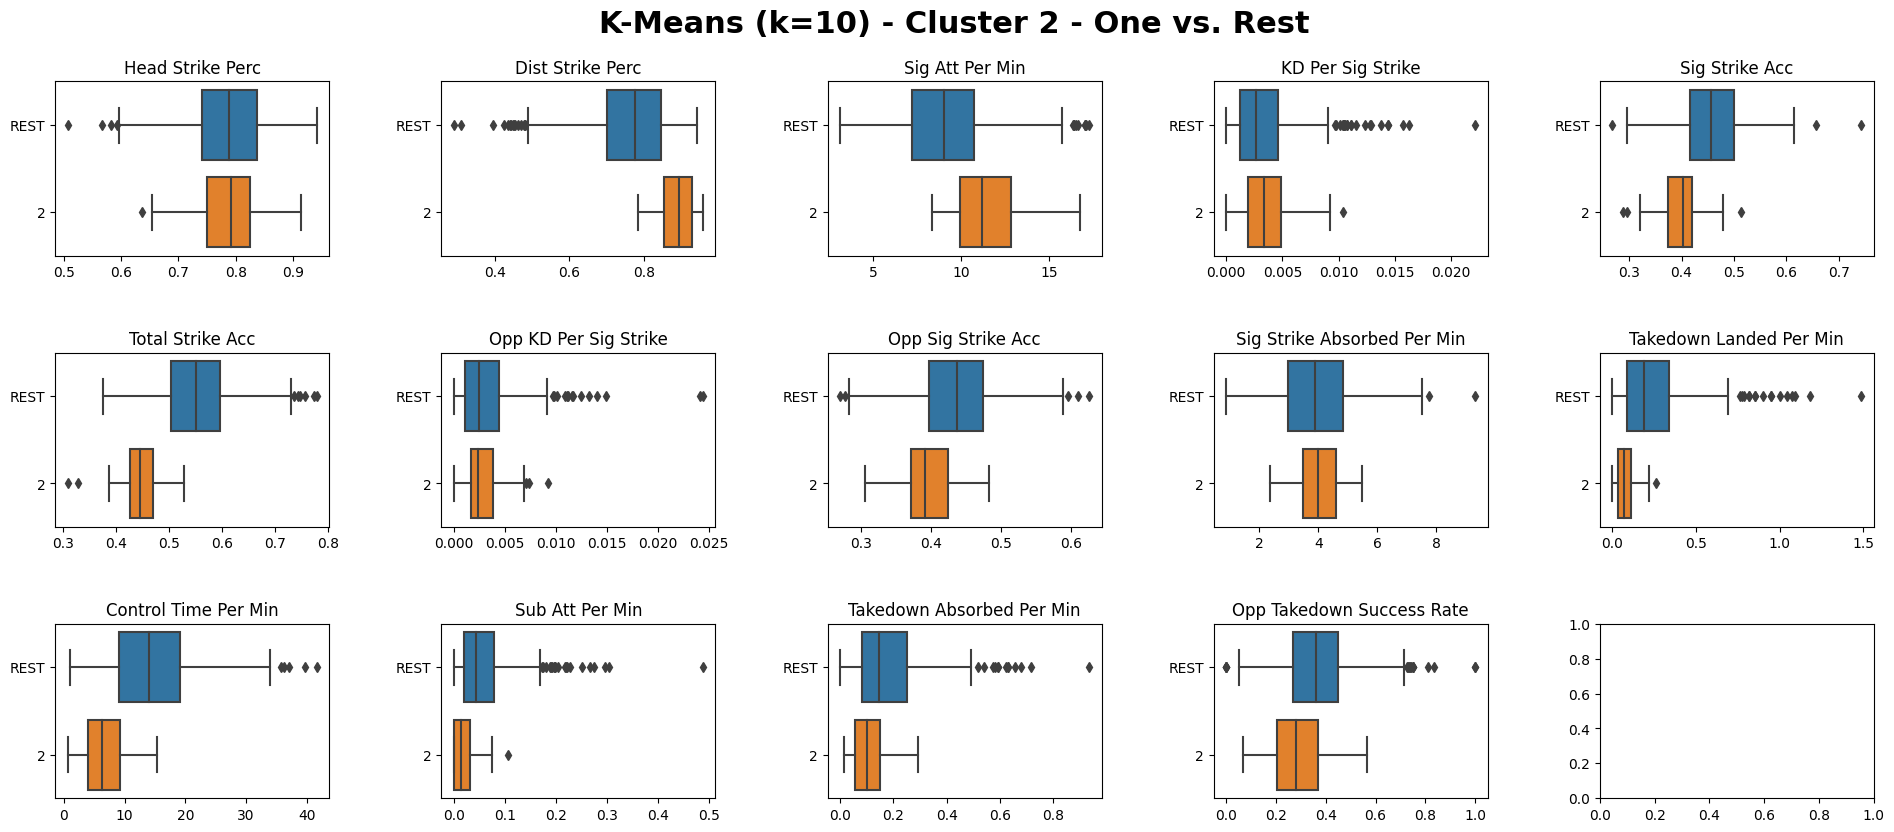

In [93]:
one_vs_rest_box(cluster_data_km_10.iloc[:,0:-1].copy(), 'cluster_kmeans_10', 2, 5, 'K-Means (k=10)')

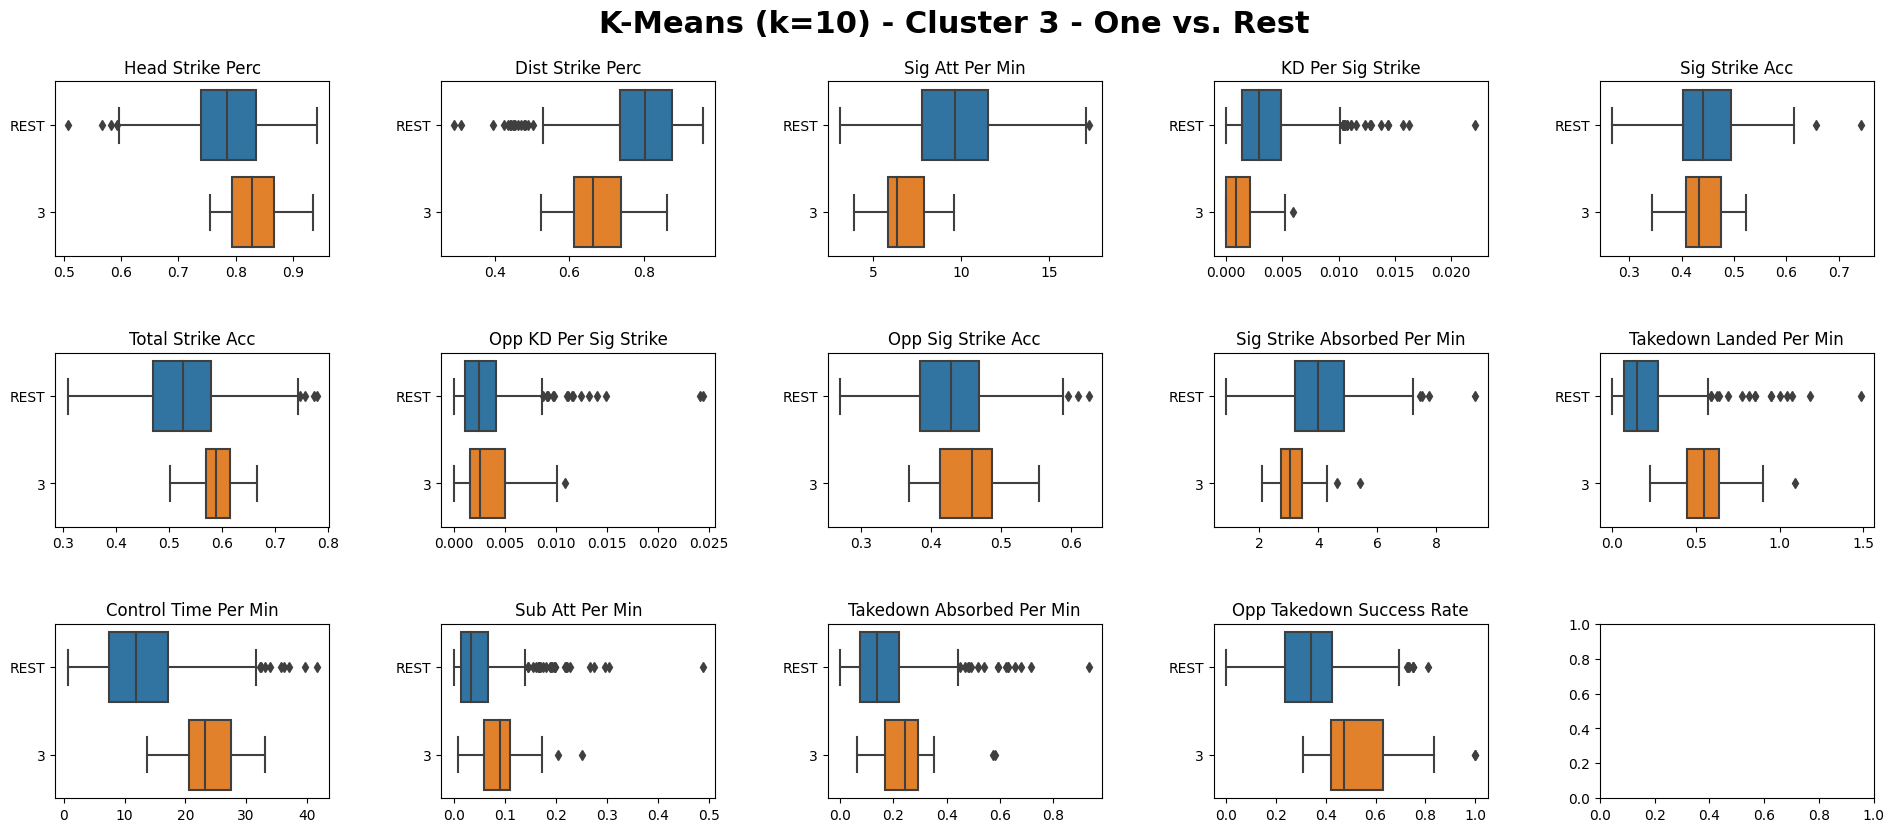

In [94]:
one_vs_rest_box(cluster_data_km_10.iloc[:,0:-1].copy(), 'cluster_kmeans_10', 3, 5, 'K-Means (k=10)')

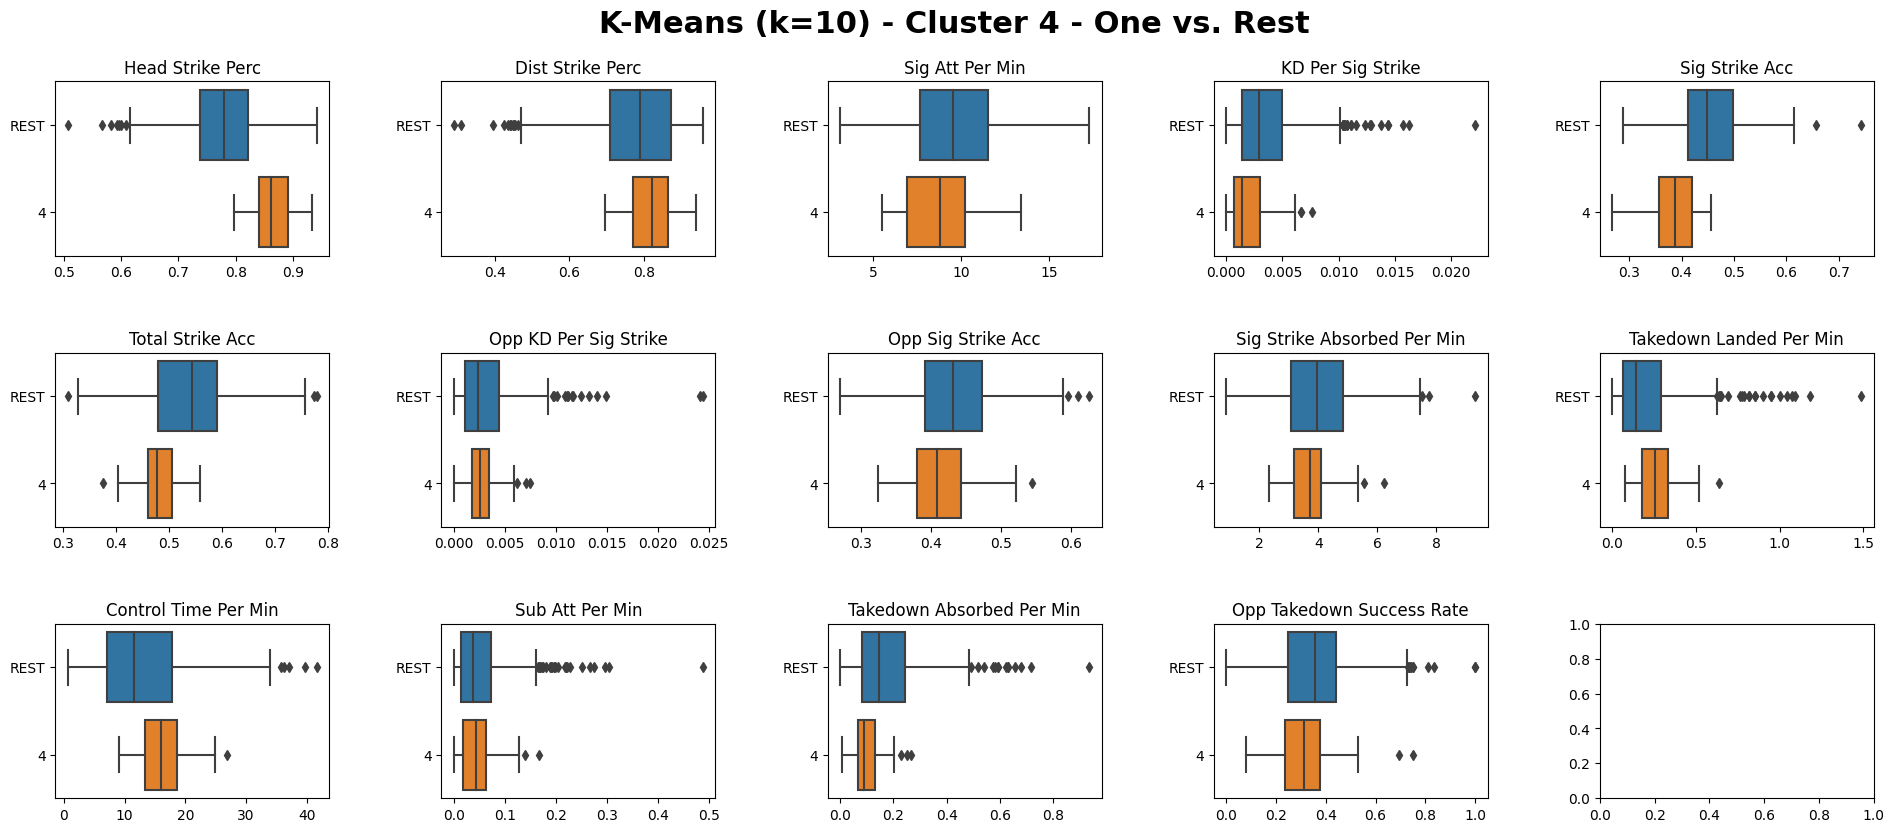

In [95]:
one_vs_rest_box(cluster_data_km_10.iloc[:,0:-1].copy(), 'cluster_kmeans_10', 4, 5, 'K-Means (k=10)')

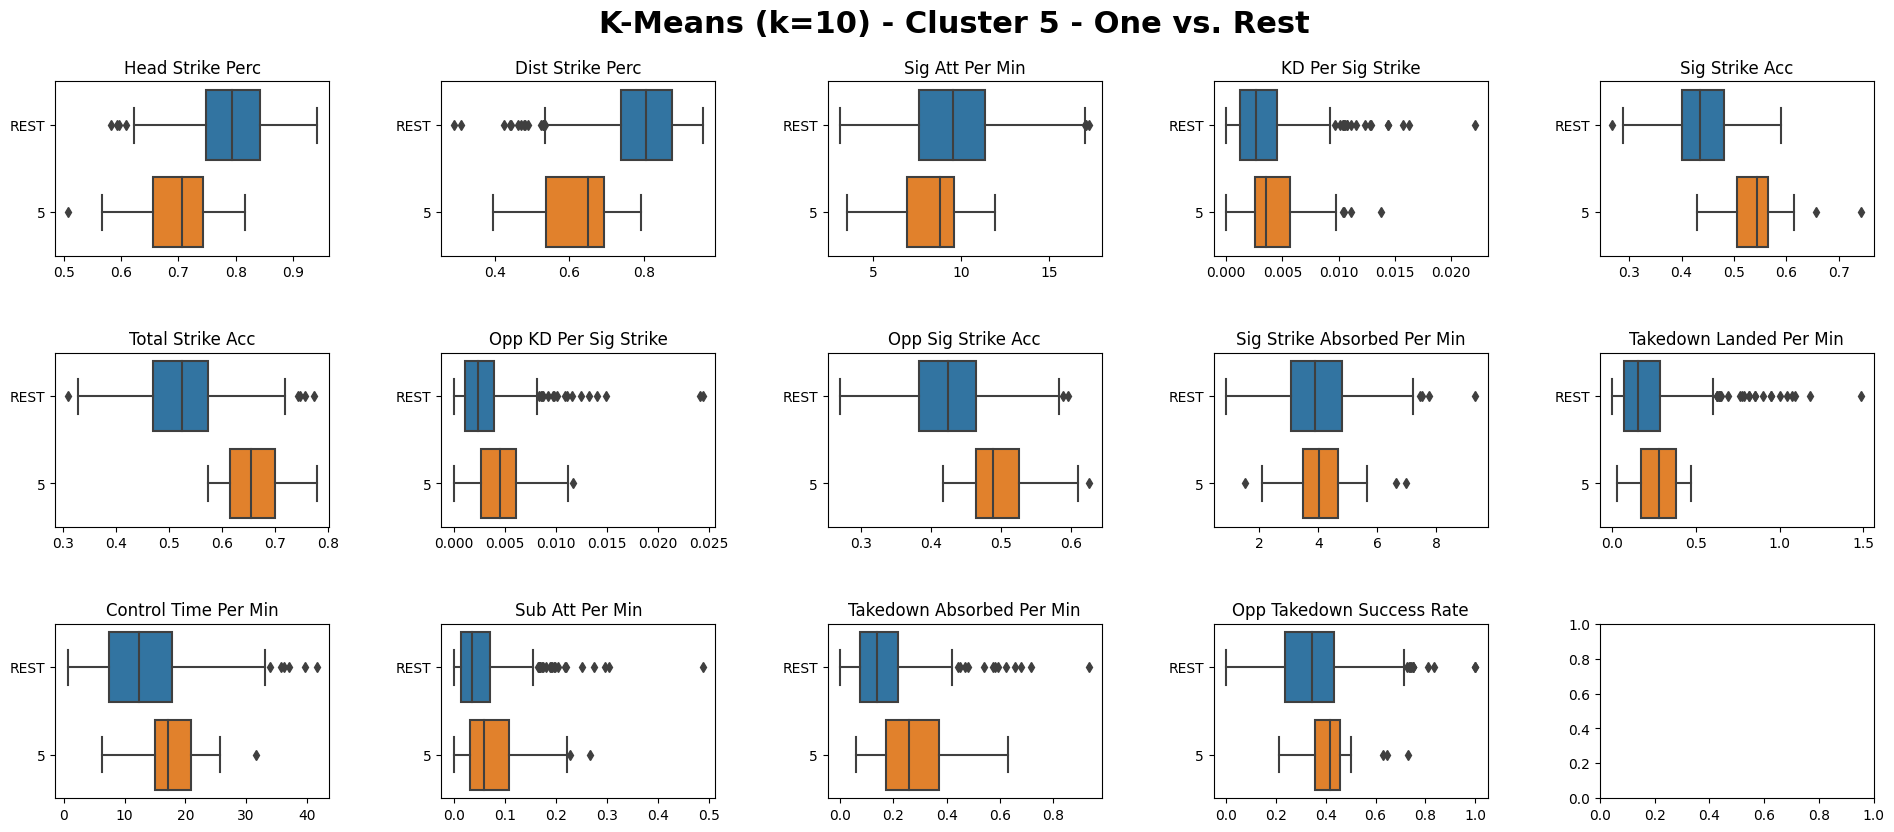

In [96]:
one_vs_rest_box(cluster_data_km_10.iloc[:,0:-1].copy(), 'cluster_kmeans_10', 5, 5, 'K-Means (k=10)')

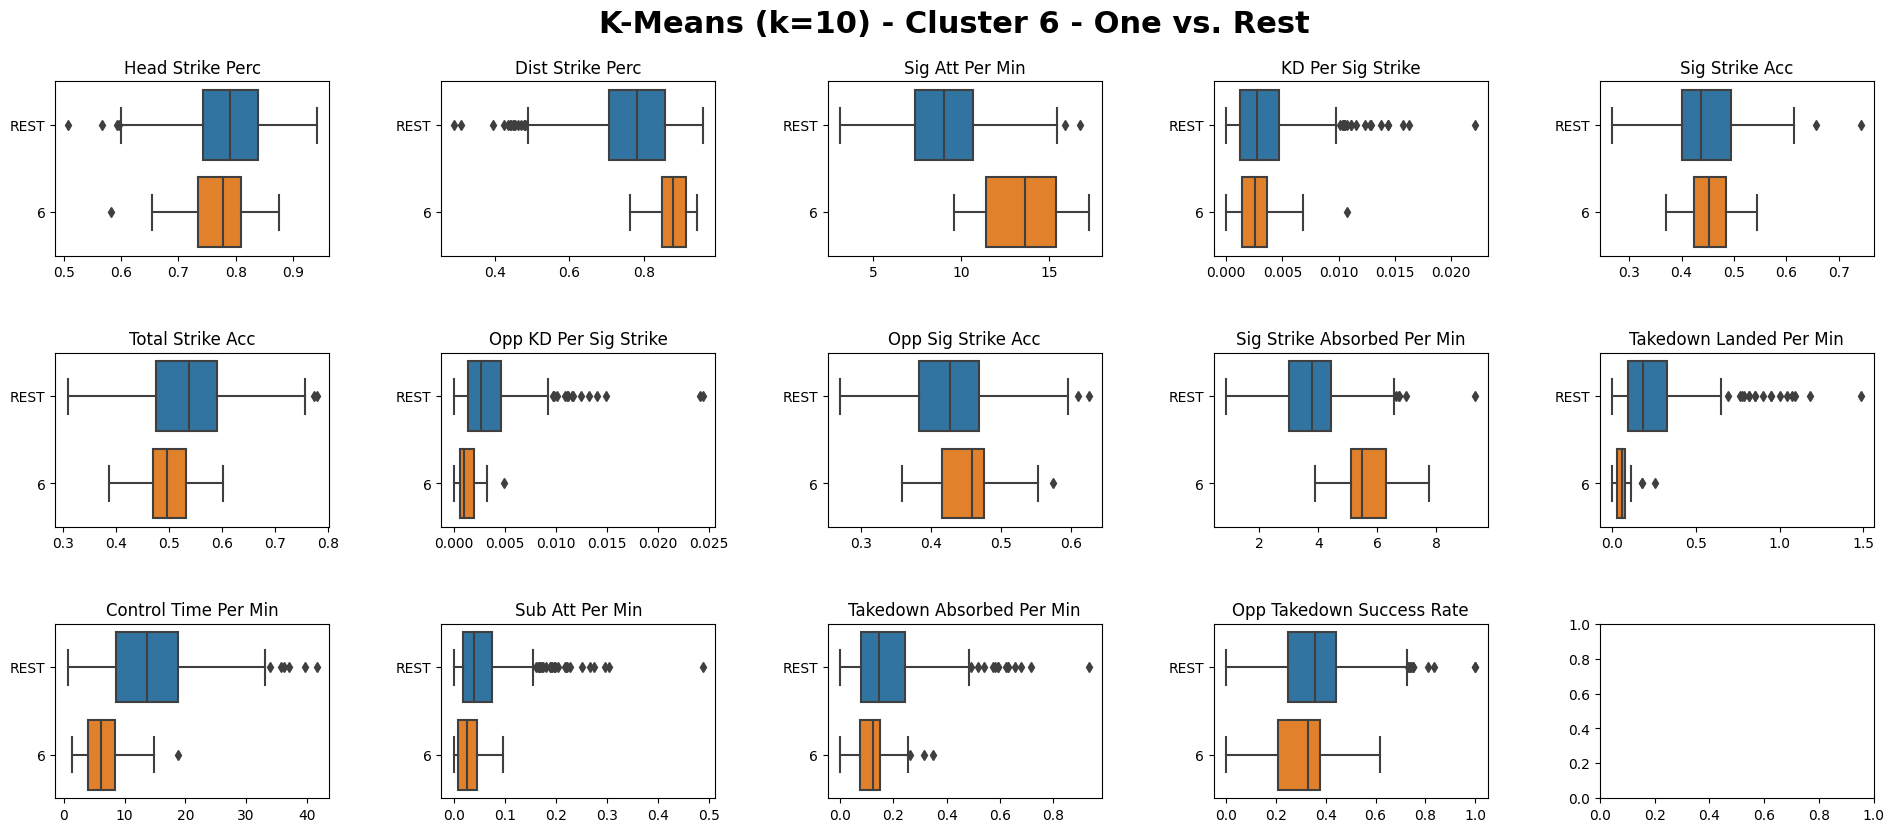

In [97]:
one_vs_rest_box(cluster_data_km_10.iloc[:,0:-1].copy(), 'cluster_kmeans_10', 6, 5, 'K-Means (k=10)')

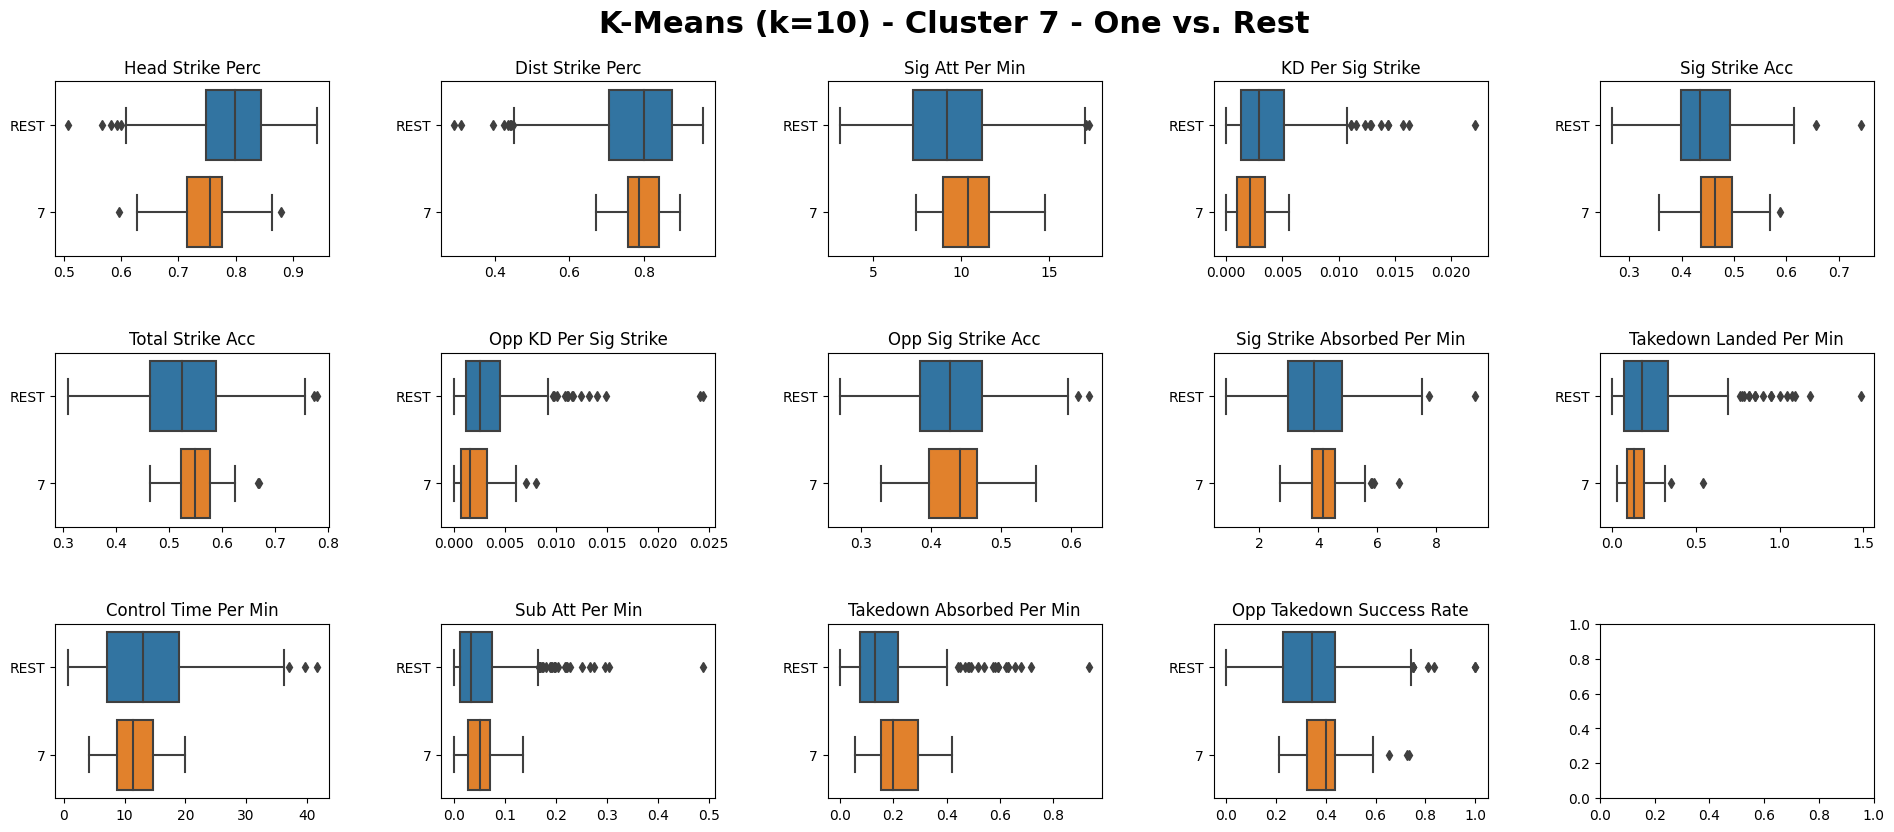

In [98]:
one_vs_rest_box(cluster_data_km_10.iloc[:,0:-1].copy(), 'cluster_kmeans_10', 7, 5, 'K-Means (k=10)')

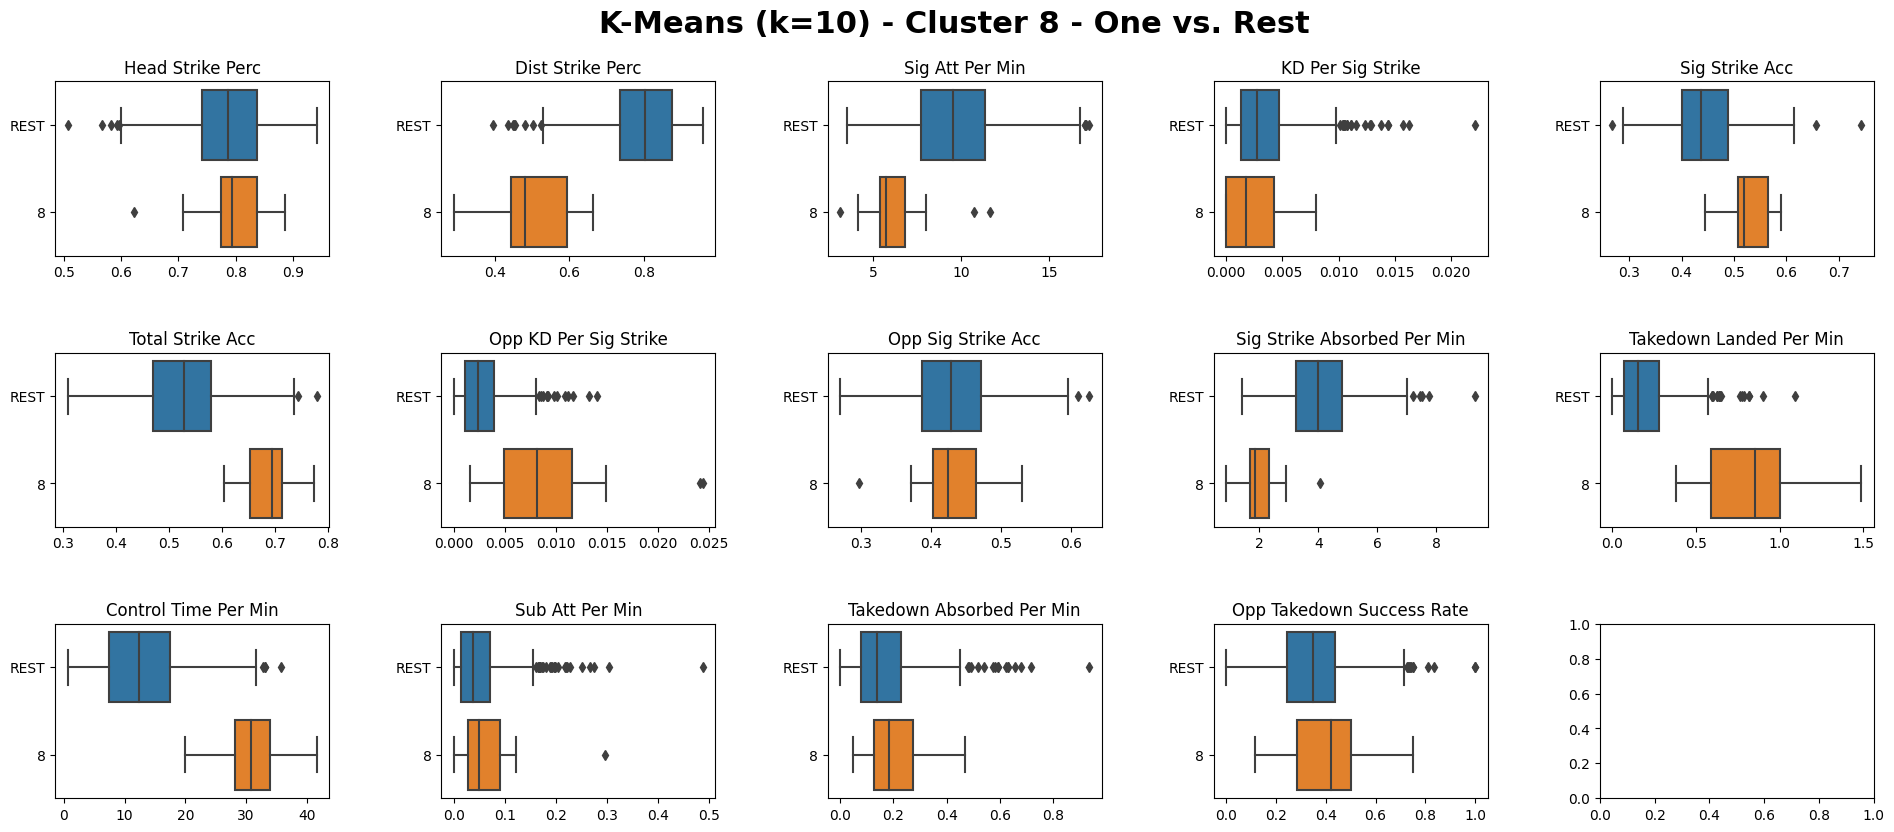

In [99]:
one_vs_rest_box(cluster_data_km_10.iloc[:,0:-1].copy(), 'cluster_kmeans_10', 8, 5, 'K-Means (k=10)')

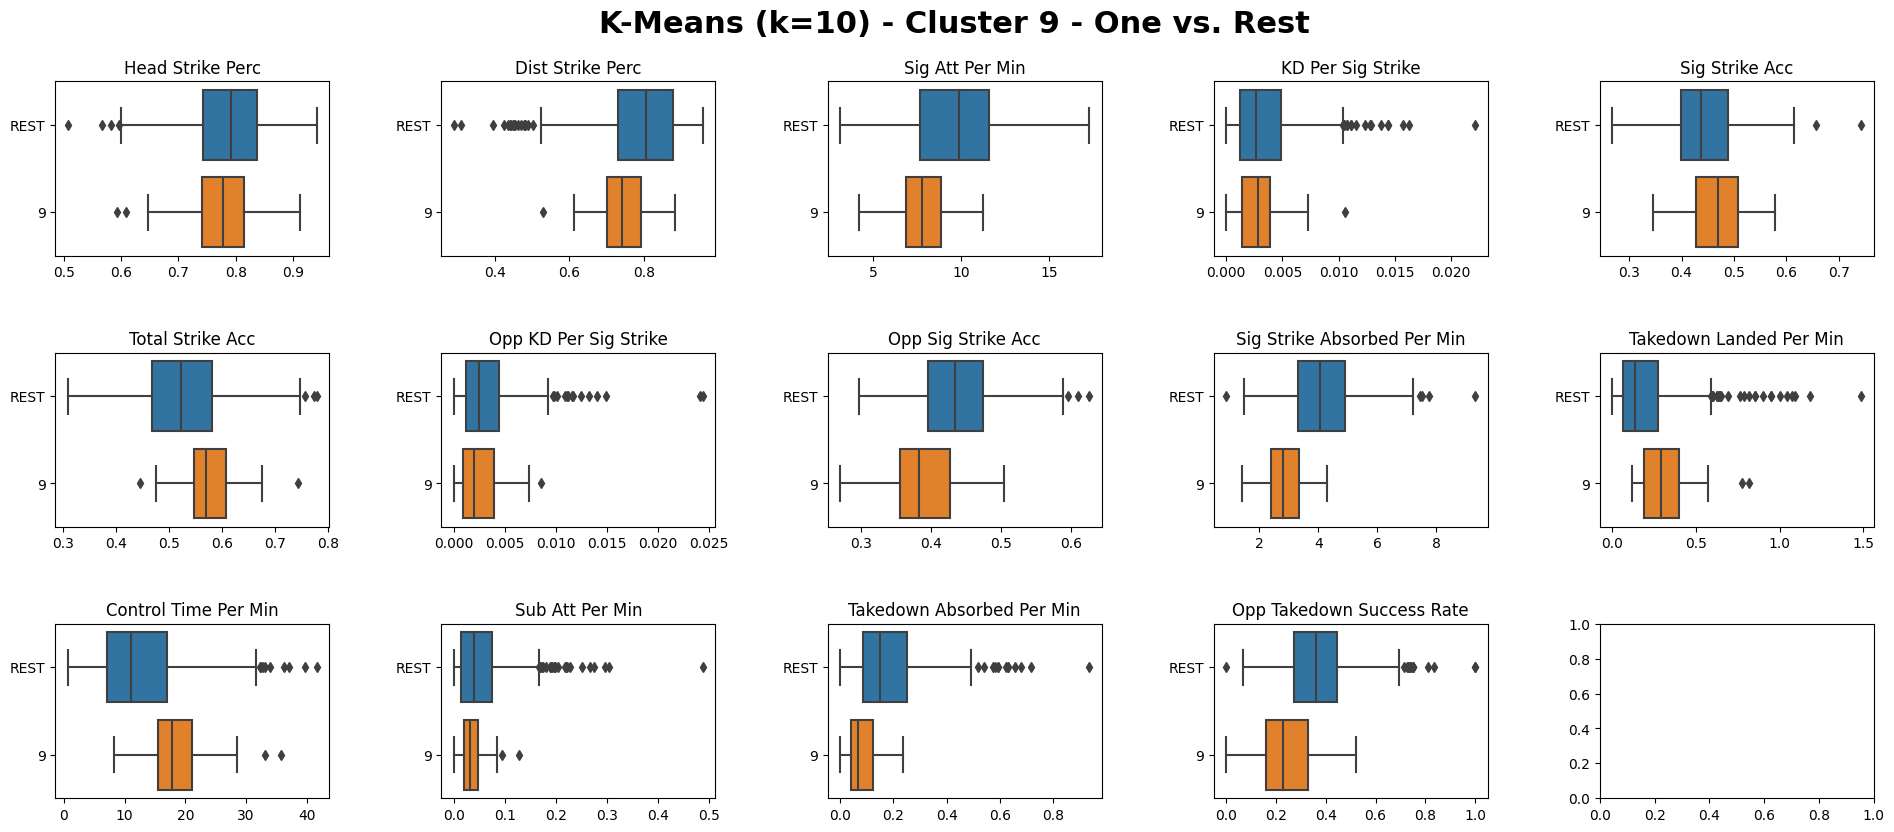

In [100]:
one_vs_rest_box(cluster_data_km_10.iloc[:,0:-1].copy(), 'cluster_kmeans_10', 9, 5, 'K-Means (k=10)')

## Cluster Breakdown by Fighter

In [101]:
# Calculate Euclidean distance from fighters to each cluster
centroids = km.cluster_centers_
nodes_to_centroids = distance.cdist(cluster_data_pca, centroids, 'euclidean')

In [102]:
# Set up dataframe of distances to cluster centroids
cols = ['Cluster 0',
        'Cluster 1',
        'Cluster 2',
        'Cluster 3',
        'Cluster 4',
        'Cluster 5',
        'Cluster 6',
        'Cluster 7',
        'Cluster 8',
        'Cluster 9',
       ]

nodes_to_centroids_df = pd.DataFrame(nodes_to_centroids, columns=cols)

In [103]:
# Convert distances to "similiarity scores"
nodes_to_centroids_df['max_distance'] = nodes_to_centroids_df.max(axis=1)
nodes_to_centroids_df = nodes_to_centroids_df.div(nodes_to_centroids_df['max_distance'], axis=0)
nodes_to_centroids_df = 1 - nodes_to_centroids_df

# Convert similarity scores to percentages for each cluster
nodes_to_centroids_df['sum'] = nodes_to_centroids_df.sum(axis=1)
nodes_to_centroids_df = nodes_to_centroids_df.div(nodes_to_centroids_df['sum'], axis=0)

# Display percentages by fighter
cluster_breakdown = nodes_to_centroids_df[cols]
cluster_breakdown['Max Percentage'] = cluster_breakdown.max(axis=1)
cluster_breakdown['Top Cluster'] = km.fit_predict(cluster_data_pca)
cluster_breakdown

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9,Max Percentage,Top Cluster
0,0.031622,0.152018,0.000000,0.083402,0.031066,0.293880,0.011382,0.179968,0.059856,0.156806,0.293880,5
1,0.092344,0.106563,0.147105,0.055169,0.111531,0.074342,0.186971,0.133090,0.000000,0.092885,0.186971,6
2,0.039907,0.020646,0.043650,0.282550,0.224155,0.025613,0.000000,0.104911,0.081607,0.176961,0.282550,3
3,0.107584,0.103055,0.113059,0.079514,0.117524,0.083083,0.153161,0.142248,0.000000,0.100773,0.153161,6
4,0.000000,0.055478,0.052307,0.184518,0.153119,0.064050,0.017291,0.089647,0.169580,0.214011,0.214011,9
...,...,...,...,...,...,...,...,...,...,...,...,...
398,0.096634,0.092475,0.173688,0.069891,0.139941,0.050107,0.138259,0.135548,0.000000,0.103457,0.173688,2
399,0.029031,0.124482,0.000000,0.152802,0.086550,0.203820,0.024566,0.145305,0.052623,0.180820,0.203820,5
400,0.152526,0.090200,0.139539,0.088248,0.134929,0.059727,0.132659,0.127064,0.000000,0.075108,0.152526,0
401,0.106171,0.134442,0.146998,0.068666,0.123476,0.067724,0.136462,0.126128,0.000000,0.089933,0.146998,2


In [104]:
# Prep cluster breakdown table for display
cluster_breakdown_display = cluster_breakdown[cols].copy()
cluster_breakdown_display['fighter_id'] = cluster_metrics['fighter_id']
cluster_breakdown_display = cluster_breakdown_display.merge(fighter_details[['fighter_id', 'first_name', 'last_name']], on='fighter_id')
cluster_breakdown_display = cluster_breakdown_display[['last_name', 'first_name'] + cols].sort_values('last_name')

# Change column names
cluster_breakdown_display.columns = ['Last Name', 
                                     'First Name',
                                     'High Risk Sub Artist',
                                     'Patient Power',
                                     'Spray and Pray',
                                     'Pressure Wrestler',
                                     'Head Hunting Wrestler',
                                     'Glass Cannon',
                                     'Stand and Bang',
                                     'Scrappy Guard', 
                                     'Chinny Grappler',
                                     'Tactician'
                                    ]

# Style the table and display
cluster_breakdown_display_styled = cluster_breakdown_display.style.background_gradient(cmap=cm, axis=1)

In [118]:
cluster_breakdown_display_styled

,Last Name,First Name,High Risk Sub Artist,Patient Power,Spray and Pray,Pressure Wrestler,Head Hunting Wrestler,Glass Cannon,Stand and Bang,Scrappy Guard,Chinny Grappler,Tactician
28,Adesanya,Israel,0.060310,0.153375,0.146231,0.052236,0.106678,0.082054,0.131566,0.137755,0.000000,0.129794
33,Akhmedov,Omari,0.083223,0.095012,0.157022,0.089289,0.185948,0.038703,0.113159,0.123278,0.000000,0.114365
67,Alcantara,Iuri,0.122908,0.127033,0.124785,0.096922,0.143112,0.063588,0.079195,0.126329,0.000000,0.116128
127,Aldana,Irene,0.110863,0.158803,0.108976,0.074863,0.090319,0.113934,0.100375,0.146153,0.000000,0.095715
318,Aldo,Jose,0.074945,0.118414,0.140803,0.055341,0.103836,0.082003,0.163545,0.150250,0.000000,0.110864
216,Almeida,Ricardo,0.150944,0.099771,0.101615,0.099336,0.100502,0.105626,0.093248,0.159999,0.000000,0.088958
61,Almeida,Thomas,0.087573,0.103517,0.182033,0.068284,0.153615,0.039751,0.132071,0.125185,0.000000,0.107971
326,Alves,Warlley,0.057777,0.094528,0.023660,0.155774,0.088863,0.146031,0.000000,0.079549,0.232942,0.120876
71,Alves,Thiago,0.079050,0.096073,0.134710,0.071310,0.112632,0.077869,0.147758,0.165438,0.000000,0.115161
319,Alvey,Sam,0.023154,0.135658,0.092678,0.085455,0.125844,0.100104,0.108999,0.155065,0.000000,0.173044


In [106]:
# Export PNG and CSV files for styled table
#dfi.export(cluster_breakdown_display_styled, 'cluster_breakdown_by_fighter.png', max_rows=-1)
#cluster_breakdown_display.to_csv('cluster_breakdown_by_fighter.csv')

In [107]:
# Describe cluster breakdown table
cluster_breakdown[cols].describe()

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8,Cluster 9
count,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000,403.000000
mean,0.082760,0.108177,0.105902,0.102624,0.122046,0.093439,0.096096,0.135067,0.027529,0.126359
std,0.052635,0.038018,0.053129,0.050936,0.040485,0.053915,0.052694,0.023088,0.063521,0.042197
min,0.000000,0.020646,0.000000,0.027624,0.003730,0.000000,0.000000,0.070891,0.000000,0.022267
25%,0.053174,0.088372,0.071912,0.065655,0.101700,0.058546,0.056774,0.122048,0.000000,0.099285
50%,0.079198,0.104340,0.119888,0.082868,0.121240,0.079280,0.107688,0.133663,0.000000,0.115657
75%,0.104828,0.124442,0.147884,0.120114,0.141934,0.114297,0.136201,0.148983,0.000000,0.146643
max,0.330514,0.256076,0.185676,0.288969,0.253176,0.293880,0.189132,0.217079,0.298890,0.250076


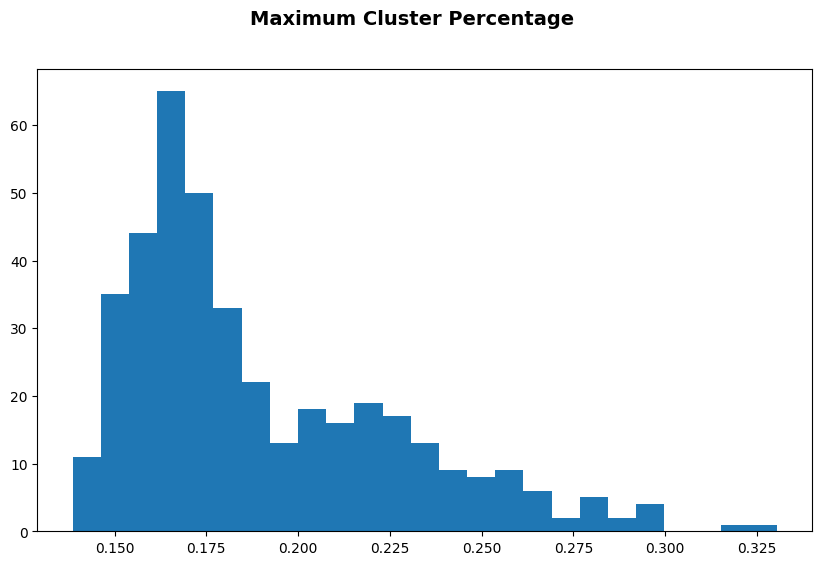

In [108]:
# Display Maximum Cluster Percentage histogram
fig = plt.figure(figsize=[10,6])
fig.suptitle('Maximum Cluster Percentage', fontsize=14, fontweight='bold')
plt.hist(cluster_breakdown['Max Percentage'], bins=25)
plt.show();

## Fighter Style Matchups

In [109]:
# Start with fighter ID's
style_matchups = fight_details[['fighter_1_id', 'fighter_2_id', 'winner_id']]

In [110]:
# Add loser ID
style_matchups['loser_id'] = np.where(style_matchups['winner_id']==style_matchups['fighter_1_id'],
                                      style_matchups['fighter_2_id'], style_matchups['fighter_1_id'])

In [111]:
# Merge cluster information for the winner and loser and filter to relevant columns (change names)
fighter_top_cluster = cluster_data_km_10[['cluster_kmeans_10', 'fighter_id']]

style_matchups = style_matchups.merge(fighter_top_cluster, left_on='winner_id', right_on='fighter_id')
style_matchups = style_matchups.merge(fighter_top_cluster, left_on='loser_id', right_on='fighter_id')

style_matchups = style_matchups[['winner_id', 'cluster_kmeans_10_x', 'loser_id', 'cluster_kmeans_10_y']]
style_matchups.columns = ['winner_id', 'winner_cluster', 'loser_id', 'loser_cluster']

In [112]:
# Group by winner and loser ID's to determine which clusters win over others in their matchups
winners = style_matchups.groupby(['winner_cluster', 'loser_cluster']).size().unstack(fill_value=0)
losers = style_matchups.groupby(['loser_cluster', 'winner_cluster']).size().unstack(fill_value=0)

# Calculate win percentage by cluster matchup
win_percentage = winners / (winners + losers)

In [113]:
# Display win percentages by cluster matchup
win_percentage.style.background_gradient(cmap=cm, axis=None)

loser_cluster,0,1,2,3,4,5,6,7,8,9
winner_cluster,,,,,,,,,,
0,0.500000,0.400000,0.400000,0.315789,0.333333,0.400000,0.190476,0.297297,0.266667,0.105263
1,0.600000,0.500000,0.555556,0.500000,0.463415,0.617647,0.388889,0.484848,0.480000,0.352941
2,0.600000,0.444444,0.500000,0.655172,0.608108,0.516129,0.411765,0.589474,0.619048,0.413793
3,0.684211,0.500000,0.344828,0.500000,0.354839,0.333333,0.583333,0.536585,0.428571,0.363636
4,0.666667,0.536585,0.391892,0.645161,0.500000,0.541667,0.473684,0.566265,0.500000,0.348485
5,0.600000,0.382353,0.483871,0.666667,0.458333,0.500000,0.230769,0.435897,0.142857,0.366667
6,0.809524,0.611111,0.588235,0.416667,0.526316,0.769231,0.500000,0.512500,0.142857,0.394737
7,0.702703,0.515152,0.410526,0.463415,0.433735,0.564103,0.487500,0.500000,0.714286,0.381579
8,0.733333,0.520000,0.380952,0.571429,0.500000,0.857143,0.857143,0.285714,0.500000,0.222222


In [114]:
# Display total number of meetings between each cluster in the dataset
(winners + losers)

loser_cluster,0,1,2,3,4,5,6,7,8,9
winner_cluster,,,,,,,,,,
0,12,20,30,19,30,20,21,37,15,19
1,20,82,63,16,41,34,18,33,25,51
2,30,63,166,29,74,31,85,95,21,87
3,19,16,29,18,31,9,12,41,7,33
4,30,41,74,31,52,24,38,83,10,66
5,20,34,31,9,24,28,26,39,14,30
6,21,18,85,12,38,26,92,80,7,38
7,37,33,95,41,83,39,80,60,14,76
8,15,25,21,7,10,14,7,14,8,18
